# **Automated Flood Mapping Using Sentinel 1**




Source: https://courses.spatialthoughts.com/gee-water-resources-management.html



In [1]:
!pip install geomet rasterstats rasterio earthpy geemap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
import ee
ee.Authenticate()
ee.Initialize(project='ee-janet')

In [4]:
import ee
import pandas as pd
from datetime import datetime, timedelta,date
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import csv
from geomet import wkt
from shapely.wkt import loads
import itertools
from rasterstats import zonal_stats
import geemap
import os
os.chdir('/content/drive/MyDrive/Remote_sensing/SRV_flooding_detection_models/Sentinel_1/current_work/')

In [5]:
grid_path = '/content/drive/MyDrive/Remote_sensing/SRV_flooding_detection_models/Dagana/geojson_files/dagana_52_grids/grid52_dagana.geojson'

# **Current codes**

In [7]:
import ee
import geemap
# Create the ImageCollection of VV polarization, IW mode
imgVV = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    .select('VH')
    .filterBounds(dagana)
    .map(
        lambda image: image.updateMask(
            image.mask().And(image.lt(-50.0).Not())
        )
    )
)

# Separate ascending and descending passes
desc = imgVV.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
asc = imgVV.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))

# Define seasonal filters
spring = ee.Filter.date('2023-01-07', '2023-01-13')
late_spring = ee.Filter.date('2023-01-07', '2023-01-13')
summer = ee.Filter.date('2023-01-07', '2023-01-13')

# Create 3-band images by concatenating mean images of each season
asc_change = ee.Image.cat(
    asc.filter(spring).median(),
    asc.filter(late_spring).median(),
    asc.filter(summer).median()
)

# Get the bounding box and center of the ROI for the Folium map
roi_bounds = dagana.bounds().getInfo()['coordinates'][0]
center_lat = (roi_bounds[0][1] + roi_bounds[2][1]) / 2
center_lon = (roi_bounds[0][0] + roi_bounds[2][0]) / 2

# Create a map for visualization
Map = geemap.Map(center=[center_lat, center_lon], zoom=10)
# Add basemap
Map.add_basemap('Esri.WorldImagery')
# Add layers to the map
viz_params = {'min': -25, 'max': 5}
Map.addLayer(asc_change.clip(dagana), viz_params, 'Multi-T Mean ASC')


# Display the map (in a notebook environment)
Map


NameError: name 'dagana' is not defined

In [13]:
#@title Updated Flood Detection Code

import datetime
from datetime import datetime, timedelta
import itertools
import json

# Geospatial and data analysis libraries
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import mapping
from shapely.wkt import loads

# Earth Engine and visualization
import ee
import geemap
from tqdm import tqdm
from IPython.display import display


# Define the grid and region of interest
grid = ee.FeatureCollection("projects/ee-janet/assets/senegal/52_grid_dagana")
init_dagana = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana")

# Additional layers from OpenStreetMap data
dagana_reservoir = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_reservoir")
dagana_water = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_water")
dagana_riverbanks = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_riverbanks")
dagana_wetland = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_wetland")
exclusion_area = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_exclusion_region")

# Exclude the permanent water areas
exclusion_areas = (
    dagana_riverbanks.geometry()
    .union(dagana_wetland.geometry())
    .union(dagana_reservoir.geometry())
    .union(dagana_water.geometry())
)

# Subtract exclusion areas from the initial Dagana region
dagana = init_dagana.geometry().difference(exclusion_areas)

# Get the bounding box and center of the ROI for the Folium map
roi_bounds = dagana.bounds().getInfo()['coordinates'][0]
center_lat = (roi_bounds[0][1] + roi_bounds[2][1]) / 2
center_lon = (roi_bounds[0][0] + roi_bounds[2][0]) / 2

# Create a map for visualization
m = geemap.Map(center=[center_lat, center_lon], zoom=10)
# Add basemap
m.add_basemap('Esri.WorldImagery')


def _refined_lee_filter(image, polarization):
    """
    Apply Refined Lee speckle filter to reduce noise while preserving edges.
    """
    # Parameters
    kernel_size = 7
    kernel_weights = ee.List.repeat(ee.List.repeat(1, kernel_size), kernel_size)
    kernel = ee.Kernel.fixed(kernel_size, kernel_size, kernel_weights)

    def apply_filter_to_band(bandName):
        band = image.select(bandName)
        mean = band.reduceNeighborhood(ee.Reducer.mean(), kernel)
        variance = band.reduceNeighborhood(ee.Reducer.variance(), kernel)

        # Coefficient of variation
        ci = variance.sqrt().divide(mean)

        # Refined Lee filter parameters
        looks = 4
        cu = np.sqrt(1.0 / looks)  # homogeneous region threshold
        cmax = np.sqrt(2.0) * cu   # maximum allowable coefficient of variation

        # Pixel weights
        w1 = ci.lt(cu)   # Homogeneous
        w2 = ci.gt(cmax) # Heterogeneous
        w3 = ci.gte(cu).And(ci.lte(cmax))  # Mixed

        # Filter result
        filtered = ee.Image.constant(0) \
            .where(w1, mean) \
            .where(w2, band) \
            .where(w3, mean.multiply(0.5).add(band.multiply(0.5)))
        return filtered.rename(bandName)

    # Apply filter to the chosen band
    band_names = polarization
    filtered_bands = [
        apply_filter_to_band(band) for band in band_names
        if image.bandNames().contains(band)
    ]

    return ee.Image.cat(filtered_bands).copyProperties(image, image.propertyNames())


def date_processing(start_date, end_date, interval_days=5):
    """
    Process date ranges for flood detection.
    """
    start_date_ = datetime.strptime(start_date, "%Y-%m-%d")
    end_date_ = datetime.strptime(end_date, "%Y-%m-%d")
    date_list = []
    while start_date_ <= end_date_:
        date_list.append(start_date_.strftime("%Y-%m-%d"))
        start_date_ += timedelta(days=interval_days)
    return date_list


def calculate_grid_flood_area(flood_mask, grid, date):
    """
    Calculate flood area for each grid cell.
    """
    def calculate_area(feature):
        area = flood_mask.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=feature.geometry(),
            scale=10,
            maxPixels=1e13
        )
        area_ha = area.getNumber('constant').divide(10000).format('%.2f')
        return feature.set({'flood_area_ha': area_ha, 'date': date})

    return grid.map(calculate_area)


def get_doy(date_string):
    """Get the day of year (1–365/366) for a given date string."""
    date = datetime.strptime(date_string, '%Y-%m-%d')
    return date.timetuple().tm_yday


def extract_flood_data(features, date):
    """
    Extract flood data from a FeatureCollection's .getInfo()['features'] structure.
    """
    flood_data = []
    for feature in features:
        grid_id = feature['properties']['ID']
        flood_area_ha = feature['properties'].get('flood_area_ha', 0)
        flood_data.append({
            'date': date,
            'grid_id': grid_id,
            'flood_area_ha': flood_area_ha,
            **{k: v for k, v in feature['properties'].items()
               if k != 'flood_area_ha'}
        })
    return flood_data


def create_flood_dataframe(flood_data):
    """
    Convert list of dictionaries to a Pandas DataFrame and set multi-index.
    """
    df = pd.DataFrame(flood_data)
    if df.empty:
        return pd.DataFrame()  # return empty if no data
    df['date'] = pd.to_datetime(df['date'])
    df.set_index(['date', 'grid_id'], inplace=True)
    return df


def process_flood_results(df, grid_properties):
    """
    Post-process the flood results to merge with any additional grid properties.
    """
    df['flood_area_ha'] = pd.to_numeric(df['flood_area_ha'], errors='coerce').fillna(0)
    if isinstance(grid_properties, pd.DataFrame):
        final_df = pd.merge(df.reset_index(), grid_properties, on='grid_id', how='left')
    else:
        final_df = df
    return final_df


def get_unique_dates(image_collection):
    """
    Get unique dates from an image collection.
    """
    dates = image_collection.aggregate_array('system:time_start')
    unique_dates = dates.distinct().sort()
    formatted_dates = unique_dates.map(lambda date: ee.Date(date).format('YYYY-MM-dd'))
    return formatted_dates


# Example reference dataset (from JRC in your snippet)
dataset = ee.Image('JRC/GSW1_4/MonthlyHistory/2021_01').clip(dagana)
water = dataset.select('water').eq(2)  # create a binary water mask

polarization = "VV"


def process_each_date(aoi, date, polarization):
    """
    For each date, process Sentinel-1 images within +/- 5 days to create a flood mask.
    """
    start_period = datetime.strptime(date, "%Y-%m-%d")# - timedelta(days=5)
    end_period = datetime.strptime(date, "%Y-%m-%d") + timedelta(days=7)
    #print(start_period, end_period)
    imgPOL = (ee.ImageCollection('COPERNICUS/S1_GRD')
          .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
          .filter(ee.Filter.eq('instrumentMode', 'IW'))
          .select('VV')
          .filterBounds(aoi)
          .map(
              lambda image: image.updateMask(
                  image.mask().And(image.lt(-35.0).Not())
              )
          )
          )
    asc = imgPOL.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
    date_col = ee.Filter.date(start_period, end_period)


    # s1_grd_col = (
    #     ee.ImageCollection("COPERNICUS/S1_GRD")
    #     .filter.date(start_period, end_period)\
    #     .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    #     #.filter(ee.Filter.eq('resolution_meters', 10))\
    #     .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))\
    #     .filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarization))\
    #     .filterBounds(aoi)\
    #     .select(polarization)\
    # )

    # Check if the image collection is empty
    if asc.size().getInfo() == 0:
      #print(asc.size().getInfo())
      print(f"No images found for date {date} with polarization {polarization}.")
      return None

    def preprocess_image(img):
        """Preprocess single Sentinel-1 image (log scaling + refined Lee)."""
        img = img.select(polarization)
        img_db = ee.Image.constant(10).multiply(img.log10())
        img_filtered = _refined_lee_filter(img_db, polarization)
        return img_filtered

    processed_col = asc.map(preprocess_image)

    # Mosaic the images
    composite = ee.Image.cat(asc.filter(date_col).mosaic())
    #composite = processed_col.mosaic()
    band_names = composite.bandNames().getInfo()
    if polarization not in band_names:
        print(f"Mosaic has no band '{polarization}' (got {band_names}), skipping date {date}.")
        return None

    # (Optional) Exclude permanent water if desired
    composite_ = composite.updateMask(water.Not())

    # Choose a threshold based on polarization
    threshold = -19 #if polarization == 'VH' else -15

    water_mask = composite_.select(polarization).lt(threshold)
    connected_pixels = water_mask.connectedPixelCount()

    # Keep only connected areas larger than a certain pixel count
    final_mask = water_mask.updateMask(connected_pixels.gt(8))

    # If final_mask ends up fully masked, you can check that here if desired
    return final_mask.clip(aoi)


def export_image(image, description, region, folder):
    """
    Export an Earth Engine image to Google Drive.
    """
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        folder=folder,
        scale=10,
        region=region,
        maxPixels=1e13
    )
    task.start()
    print(f"Started export task for {description}")


# Projection reference
prev_s1_coll = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
    .filterBounds(dagana)
    .filterDate('2022-12-01', '2022-12-31')
)

# Get the projection of the chosen polarization
projection = prev_s1_coll.mosaic().clip(dagana).select(polarization).projection()


def process_and_visualize_flooding(aoi, date_ranges, grid):
    """
    Process and visualize flooding, mapping only at the end of each month,
    then export cumulative maps.
    """
    flood_data = []
    # Start with an empty image for accumulation
    cumulative_flood_mask = ee.Image(0).reproject(crs=projection, scale=10).clip(aoi)
    flood_vis_params = {
        'min': min([get_doy(d) for d in date_ranges]),
        'max': max([get_doy(d) for d in date_ranges]),
        'palette': ['blue', 'cyan', 'green', 'yellow', 'red']
    }

    current_month = None

    for i, date in tqdm(enumerate(date_ranges), total=len(date_ranges), desc="Processing Dates"):
        current_pol_area = process_each_date(aoi, date, polarization)
        if current_pol_area is None:
            print(f"Skipping date {date} - no valid data for {polarization}.")
            continue

        # Update cumulative flood mask
        doy = get_doy(date)
        cumulative_flood_mask = cumulative_flood_mask.where(
            current_pol_area.And(cumulative_flood_mask.eq(0)), doy
        )

        # Calculate flood area for the grid
        grid_with_flood_area = calculate_grid_flood_area(
            cumulative_flood_mask.gt(0), grid, date
        )

        # ----------------------------
        # Safely check if grid_with_flood_area has features
        try:
            fc_info = grid_with_flood_area.getInfo()
            features = fc_info.get('features', [])
        except Exception as e:
            print(f"Error retrieving features for date {date}: {e}")
            print("Skipping this date.")
            continue

        if not features:
            print(f"Date {date}: No flooded area in the grid; skipping.")
            continue

        flood_data.extend(extract_flood_data(features, date))

        # End-of-month logic
        date_obj = datetime.strptime(date, "%Y-%m-%d")
        if current_month is None:
            current_month = date_obj.month

        is_end_of_month = (
            i == len(date_ranges) - 1 or
            datetime.strptime(date_ranges[i + 1], "%Y-%m-%d").month != current_month
        )

        if is_end_of_month:
            # Add layer to map
            layer_name = f'{polarization}_Flooding_Progression_up_to_{date}'
            m.add_layer(
                cumulative_flood_mask.updateMask(cumulative_flood_mask.gt(0)),
                flood_vis_params,
                layer_name
            )

            # Export the cumulative flood mask
            export_folder = "fis_flooding_maps"
            export_image(
                cumulative_flood_mask.updateMask(cumulative_flood_mask.gt(0)),
                f'{polarization}_Flooding_map_{date}',
                aoi,
                export_folder
            )

            # Prepare for next month
            if i != len(date_ranges) - 1:
                current_month = datetime.strptime(date_ranges[i + 1], "%Y-%m-%d").month

    m.add_colorbar(
        flood_vis_params,
        label="Day of the year",
        orientation="horizontal",
        layer_name="Flooding detection"
    )
    return flood_data


# Example usage
start_date = '2023-01-07'
end_date = '2023-01-31'
date_ranges = date_processing(start_date, end_date)
print(date_ranges)
flood_data = process_and_visualize_flooding(dagana, date_ranges, grid)

# Post-process the data
df = create_flood_dataframe(flood_data).reset_index()
if df.empty:
    print("No flood data was generated.")
else:
    df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

    # Pivot the table so each date becomes its own column
    df_pivoted = df.pivot(index='grid_id', columns='date', values='flood_area_ha')

    # Simple estimation of a "flooding date" as the date of the maximum flood area
    columns_date = df_pivoted.columns
    maxValueIndex1 = df_pivoted[columns_date].idxmax(axis=1)
    df_pivoted['flooding_date'] = maxValueIndex1

    # Example: if you have extra properties in your grid
    columns_to_keep = ['ID', 'LatNP', 'Latitude', 'LonNP', 'Longitude', 'nasapid']
    df_other = df.drop_duplicates(subset=['grid_id'])[columns_to_keep + ['grid_id']].set_index('grid_id')

    df_pivoted = df_pivoted.rename_axis(index='grid_id')
    df_final = df_other.join(df_pivoted).reset_index()

    # Reorder columns, ensuring date columns appear in sorted order
    date_columns = [
        col for col in df_final.columns
        if col not in columns_to_keep + ['grid_id', 'index']
    ]
    df_final = df_final[columns_to_keep + ['grid_id'] + sorted(date_columns)]

    # Save the final DataFrame
    year = 2023
    output_file_name = f'{polarization}_floodingData_{year}.csv'
    df_final.to_csv(output_file_name, index=False)
    print(f"Saved results to {output_file_name}")

# Display the map (in Jupyter/IPython environment)
display(m)


['2023-01-07', '2023-01-12', '2023-01-17', '2023-01-22', '2023-01-27']


Processing Dates: 100%|██████████| 5/5 [04:59<00:00, 59.86s/it]

Started export task for VV_Flooding_map_2023-01-27


Saved results to VV_floodingData_2023.csv


Map(center=[16.246652189610472, -15.921360830428728], controls=(WidgetControl(options=['position', 'transparen…

In [14]:
df_final.head()

,ID,LatNP,Latitude,LonNP,Longitude,nasapid,grid_id,2023-01-07,2023-01-12,2023-01-17,2023-01-22,2023-01-27,flooding_date
0,5505644,16.25,16.208333,-16.25,-16.375000,152968,5505644,278.14,278.14,278.14,424.86,424.86,2023-01-22
1,5505643,16.25,16.208333,-16.25,-16.458333,152968,5505643,14.00,14.00,14.00,20.65,20.65,2023-01-22
2,5505648,16.25,16.208333,-16.25,-16.041667,152968,5505648,2164.81,2164.81,2271.61,2585.80,2619.31,2023-01-27
3,5505647,16.25,16.208333,-16.25,-16.125000,152968,5505647,3979.93,3979.93,4121.62,4748.20,4802.39,2023-01-27
4,5505646,16.25,16.208333,-16.25,-16.208333,152968,5505646,2303.62,2303.62,2454.97,3272.60,3347.11,2023-01-27


In [10]:
#@title Updated Flood Detection Code

import datetime
from datetime import datetime, timedelta
import itertools
import json

# Geospatial and data analysis libraries
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import mapping
from shapely.wkt import loads

# Earth Engine and visualization
import ee
import geemap
from tqdm import tqdm
from IPython.display import display


# Define the grid and region of interest
grid = ee.FeatureCollection("projects/ee-janet/assets/senegal/52_grid_dagana")
init_dagana = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana")

# Additional layers from OpenStreetMap data
dagana_reservoir = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_reservoir")
dagana_water = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_water")
dagana_riverbanks = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_riverbanks")
dagana_wetland = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_wetland")
exclusion_area = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_exclusion_region")

# Exclude the permanent water areas
exclusion_areas = (
    dagana_riverbanks.geometry()
    .union(dagana_wetland.geometry())
    .union(dagana_reservoir.geometry())
    .union(dagana_water.geometry())
)

# Subtract exclusion areas from the initial Dagana region
dagana = init_dagana.geometry().difference(exclusion_areas)

# Get the bounding box and center of the ROI for the Folium map
roi_bounds = dagana.bounds().getInfo()['coordinates'][0]
center_lat = (roi_bounds[0][1] + roi_bounds[2][1]) / 2
center_lon = (roi_bounds[0][0] + roi_bounds[2][0]) / 2

# Create a map for visualization
m = geemap.Map(center=[center_lat, center_lon], zoom=10)
# Add basemap
m.add_basemap('Esri.WorldImagery')

def _refined_lee_filter(image,polarization):
    """
    Apply Refined Lee speckle filter to reduce noise while preserving edges.
    Fixed implementation to properly handle Earth Engine band operations.
    """
    # Parameters
    kernel_size = 7
    kernel_weights = ee.List.repeat(ee.List.repeat(1, kernel_size), kernel_size)
    kernel = ee.Kernel.fixed(kernel_size, kernel_size, kernel_weights)

    # Get the bands to process
    bandName = polarization#['VV', 'VH']  # Adjust if you only want one band

    def apply_filter_to_band(bandName):
        band = image.select(bandName)

        # Mean and variance
        mean = band.reduceNeighborhood(ee.Reducer.mean(), kernel)
        variance = band.reduceNeighborhood(ee.Reducer.variance(), kernel)

        # Coefficient of variation
        ci = variance.sqrt().divide(mean)

        # Refined Lee filter parameters
        looks = 4
        cu = np.sqrt(1.0 / looks)        # homogeneous region threshold
        cmax = np.sqrt(2.0) * cu         # maximum allowable coefficient of variation

        # Pixel weights
        w1 = ci.lt(cu)   # Homogeneous
        w2 = ci.gt(cmax) # Heterogeneous
        w3 = ci.gte(cu).And(ci.lte(cmax))  # Mixed

        # Filter result
        filtered = ee.Image.constant(0) \
            .where(w1, mean) \
            .where(w2, band) \
            .where(w3, mean.multiply(0.5).add(band.multiply(0.5)))

        return filtered.rename(bandName)

    # Apply filter to each band separately
    filtered_bands = [apply_filter_to_band(band) for band in bandName if image.bandNames().contains(band)]
    # Combine into a single multi-band image
    return ee.Image.cat(filtered_bands).copyProperties(image, image.propertyNames())

def date_processing(start_date, end_date, interval_days=5):
    """
    Process date ranges for flood detection.

    Args:
        start_date (str): Start date in "YYYY-MM-DD" format.
        end_date (str): End date in "YYYY-MM-DD" format.
        interval_days (int): Interval between date ranges in days.

    Returns:
        list: List of date strings with the specified interval.
    """
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    date_list = []
    while start_date <= end_date:
        date_list.append(start_date.strftime("%Y-%m-%d"))
        start_date += timedelta(days=interval_days)
    return date_list

def calculate_grid_flood_area(flood_mask, grid, date):
    """
    Calculate flood area for each grid cell.

    Args:
        flood_mask (ee.Image): Binary image representing flooded pixels.
        grid (ee.FeatureCollection): Grid cells over AOI.
        date (str): Reference date used in the output.

    Returns:
        ee.FeatureCollection: Grid with new property for flood area.
    """
    def calculate_area(feature):
        area = flood_mask.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=feature.geometry(),
            scale=10,
            maxPixels=1e13
        )
        area_ha = area.getNumber('constant').divide(10000).format('%.2f')
        return feature.set({'flood_area_ha': area_ha, 'date': date})

    return grid.map(calculate_area)

def get_doy(date_string):
    """Get the day of year (1–365/366) for a given date string."""
    date = datetime.strptime(date_string, '%Y-%m-%d')
    return date.timetuple().tm_yday

def extract_flood_data(features, date):
    """
    Extract flood data from a FeatureCollection's .getInfo()['features'] structure.

    Args:
        features (list): List of feature dictionaries.
        date (str): Date string to attach to each record.

    Returns:
        list[dict]: List of dictionaries with date, grid_id, flood_area_ha, etc.
    """
    flood_data = []
    for feature in features:
        grid_id = feature['properties']['ID']
        flood_area_ha = feature['properties'].get('flood_area_ha', 0)
        # Include all other properties except 'flood_area_ha' to avoid duplicates
        flood_data.append({
            'date': date,
            'grid_id': grid_id,
            'flood_area_ha': flood_area_ha,
            **{k: v for k, v in feature['properties'].items() if k != 'flood_area_ha'}
        })
    return flood_data

def create_flood_dataframe(flood_data):
    """
    Convert list of dictionaries to a Pandas DataFrame and set multi-index.

    Args:
        flood_data (list[dict]): Data containing date, grid_id, flood_area_ha, etc.

    Returns:
        pd.DataFrame: DataFrame with multi-index on date and grid_id.
    """
    df = pd.DataFrame(flood_data)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index(['date', 'grid_id'], inplace=True)
    return df

def process_flood_results(df, grid_properties):
    """
    Post-process the flood results to merge with any additional grid properties.

    Args:
        df (pd.DataFrame): Flood DataFrame.
        grid_properties (pd.DataFrame): Additional grid properties to join on 'grid_id'.

    Returns:
        pd.DataFrame: Final merged DataFrame.
    """
    df['flood_area_ha'] = pd.to_numeric(df['flood_area_ha'], errors='coerce').fillna(0)
    if isinstance(grid_properties, pd.DataFrame):
        final_df = pd.merge(df.reset_index(), grid_properties, on='grid_id', how='left')
    else:
        final_df = df
    return final_df

def get_unique_dates(image_collection):
    """
    Get unique dates from an image collection.

    Args:
        image_collection (ee.ImageCollection): Earth Engine image collection.

    Returns:
        ee.List: List of unique date strings.
    """
    dates = image_collection.aggregate_array('system:time_start')
    unique_dates = dates.distinct().sort()
    formatted_dates = unique_dates.map(lambda date: ee.Date(date).format('YYYY-MM-dd'))
    return formatted_dates

# Example reference dataset (from JRC in your snippet)
dataset = ee.Image('JRC/GSW1_4/MonthlyHistory/2021_01').clip(dagana)
# Select water and create a binary mask
water = dataset.select('water').eq(2)

polarization = ["VV"]

def process_each_date(aoi, date, polarization):
    """
    For each date, process Sentinel-1 images within +/- 5 days to create a flood mask.

    Args:
        aoi (ee.Geometry): Area of interest.
        date (str): Target date.
        polarization (str): 'VV' or 'VH'.

    Returns:
        ee.Image or None: Flood mask clipped to AOI, or None if no images found.
    """
    start_period = datetime.strptime(date, "%Y-%m-%d") - timedelta(days=5)
    end_period = datetime.strptime(date, "%Y-%m-%d") + timedelta(days=5)

    s1_grd_col = (
        ee.ImageCollection("COPERNICUS/S1_GRD")
        .filterBounds(aoi)
        .filterDate(start_period, end_period)
        .filter(ee.Filter.eq('instrumentMode', 'IW'))
        .filter(ee.Filter.eq('resolution_meters', 10))
        .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarization))
    )

    # Check if the image collection is empty
    if s1_grd_col.size().getInfo() == 0:
        print(f"No images found for date {date} with polarization {polarization}.")
        return None

    def preprocess_image(img):
        """Preprocess single Sentinel-1 image (log scaling + refined Lee)."""
        # Select the polarization band
        img = img.select(polarization)
        # Convert to decibels
        img_db = ee.Image.constant(10).multiply(img.log10())
        # Apply speckle filter
        img_filtered = _refined_lee_filter(img_db,polarization)
        return img_filtered

    # Process the collection
    processed_col = s1_grd_col.map(preprocess_image)
    #print(processed_col)
    # Mosaic the images
    composite = processed_col.mosaic()
    #print(composite.bandNames().getInfo())
    # Exclude permanent water (if desired)
    # Here, you were updating the mask with water.Not(),
    # but make sure that logic is what you intend.
    composite_ = composite.updateMask(water.Not())
    # band_names = composite_.bandNames().getInfo()  # e.g. ['VV']
    # if polarization not in band_names:
    #     print(f"Mosaic has no band '{polarization}' (got {band_names}), skipping date {date}.")
    #     return None
    # Detect flooded areas based on fixed thresholds
    # Adjust thresholds based on polarization or region specifics
    threshold = -22 if polarization == 'VH' else -15
    water_mask = composite_.select(polarization).lt(threshold)

    # Keep only connected areas larger than a certain pixel count
    connected_pixels = water_mask.connectedPixelCount()
    final_mask = water_mask.updateMask(connected_pixels.gt(8))

    return final_mask.clip(aoi)

def export_image(image, description, region, folder):
    """
    Export an Earth Engine image to Google Drive.

    Args:
        image (ee.Image): The image to export.
        description (str): A descriptive name for the export task.
        region (ee.Geometry): Region to clip to.
        folder (str): Name of folder on your Google Drive.

    Returns:
        None. (Starts the Earth Engine export task.)
    """
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        folder=folder,
        scale=10,
        region=region,
        maxPixels=1e13
    )
    task.start()
    print(f"Started export task for {description}")

# Get an equivalent s1 image of the aoi to save the cumulative areas
# (This is just to get a projection reference)
prev_s1_coll = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
    .filterBounds(dagana)
    .filterDate('2022-12-01', '2022-12-31')  # Adjust date range as needed
)

# Get the projection of the VV or VH band
projection = prev_s1_coll.mosaic().clip(dagana).select(polarization).projection()

def process_and_visualize_flooding(aoi, date_ranges, grid):
    """
    Process and visualize flooding, mapping only at the end of each month,
    then export cumulative maps.

    Args:
        aoi (ee.Geometry): Area of interest.
        date_ranges (list): List of date strings.
        grid (ee.FeatureCollection): Grid to calculate flood stats.

    Returns:
        list[dict]: All flood data.
    """
    flood_data = []
    # Start with an empty image for accumulation
    cumulative_flood_mask = ee.Image(0).reproject(crs=projection, scale=10).clip(aoi)
    flood_vis_params = {
        'min': min([get_doy(d) for d in date_ranges]),
        'max': max([get_doy(d) for d in date_ranges]),
        'palette': ['blue', 'cyan', 'green', 'yellow', 'red']
    }

    current_month = None

    for i, date in tqdm(enumerate(date_ranges), total=len(date_ranges), desc="Processing Dates"):
        current_pol_area = process_each_date(aoi, date, polarization)
        #if current_pol_area is not None:
        if current_pol_area is None:
            print(f"Skipping date {date} - no valid data for {polarization}.")
            continue
        doy = get_doy(date)
        # Update cumulative flood mask where current date is flooded and it wasn't flooded before
        cumulative_flood_mask = cumulative_flood_mask.where(
            current_pol_area.And(cumulative_flood_mask.eq(0)), doy
        )

        # Calculate the flood area for the grid at each 5-day interval
        grid_with_flood_area = calculate_grid_flood_area(
            cumulative_flood_mask.gt(0), grid, date
        )
        # Check if grid_with_flood_area is empty
        # if grid_with_flood_area.size().getInfo() == 0:
        #     print(f"Date {date}: No flooded area in grid; skipping.")
        #     continue

        # Safely get features
        # fc_info = grid_with_flood_area.getInfo()
        # features = fc_info.get('features', [])
        # if not features:
        #     print(f"Date {date}: No features found; skipping.")
        #     continue
        flood_data.extend(
            extract_flood_data(grid_with_flood_area.getInfo()['features'], date)
        )

        # Check end-of-month logic
        date_obj = datetime.strptime(date, "%Y-%m-%d")
        if current_month is None:
            current_month = date_obj.month

        # If it's the last date or the next date changes the month
        is_end_of_month = (
            i == len(date_ranges) - 1 or
            datetime.strptime(date_ranges[i + 1], "%Y-%m-%d").month != current_month
        )
        if is_end_of_month:
            # Add layer to map
            layer_name = f'{polarization}_Flooding Progression up to {date}'
            m.add_layer(
                cumulative_flood_mask.updateMask(cumulative_flood_mask.gt(0)),
                flood_vis_params,
                layer_name
            )

            # Export the cumulative flood mask
            export_folder = "fis_flooding_maps"
            export_image(
                cumulative_flood_mask.updateMask(cumulative_flood_mask.gt(0)),
                f'{polarization}_Flooding_map_{date}',
                aoi,
                export_folder
            )

            # Prepare for next month
            if i != len(date_ranges) - 1:
                current_month = datetime.strptime(date_ranges[i + 1], "%Y-%m-%d").month
        # else:
        #     print(f"Skipping date {date} due to no valid {polarization} images.")

    # Add a colorbar at the end
    m.add_colorbar(
        flood_vis_params,
        label="Day of the year",
        orientation="horizontal",
        layer_name="Flooding detection"
    )
    return flood_data

# Example usage:
start_date = '2023-01-07'
end_date = '2023-03-03'
date_ranges = date_processing(start_date, end_date)
flood_data = process_and_visualize_flooding(dagana, date_ranges, grid)

# Post-process the data into a DataFrame
df = create_flood_dataframe(flood_data).reset_index()
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

# Pivot the table so each date becomes its own column
df_pivoted = df.pivot(index='grid_id', columns='date', values='flood_area_ha')

# Simple estimation of a "flooding date" as the date of the maximum flood area
columns_date = df_pivoted.columns
maxValueIndex1 = df_pivoted[columns_date].idxmax(axis=1)
df_pivoted['flooding_date'] = maxValueIndex1

# If you have extra properties in your grid you want to merge:
# columns_to_keep = ['ID', 'LatNP', 'Latitude', 'LonNP', 'Longitude', 'nasapid']
# (Dummy example; you would have to define grid_properties DataFrame accordingly)
columns_to_keep = ['ID', 'LatNP', 'Latitude', 'LonNP', 'Longitude', 'nasapid']

# Merge additional grid info if you have it in a separate DataFrame
# For now, we’ll just assume the ‘df’ from before has these columns.
df_other = df.drop_duplicates(subset=['grid_id'])[columns_to_keep + ['grid_id']].set_index('grid_id')
df_pivoted = df_pivoted.rename_axis(index='grid_id')
df_final = df_other.join(df_pivoted).reset_index()

# Reorder columns, ensuring date columns appear in sorted order
date_columns = [col for col in df_final.columns if col not in columns_to_keep + ['grid_id', 'index']]
df_final = df_final[columns_to_keep + ['grid_id'] + sorted(date_columns)]

# Save the final DataFrame
year = 2023
output_file_name = f'{polarization}_floodingData_{year}.csv'
df_final.to_csv(output_file_name, index=False)
print(f"Saved results to {output_file_name}")

# Display the map (Jupyter/IPython)
display(m)


Processing Dates:   8%|▊         | 1/12 [00:05<00:57,  5.20s/it]

No images found for date 2023-01-07 with polarization ['VV'].
Skipping date 2023-01-07 - no valid data for ['VV'].


Processing Dates:  17%|█▋        | 2/12 [00:10<00:50,  5.05s/it]

No images found for date 2023-01-12 with polarization ['VV'].
Skipping date 2023-01-12 - no valid data for ['VV'].


Processing Dates:  25%|██▌       | 3/12 [00:14<00:44,  4.95s/it]

No images found for date 2023-01-17 with polarization ['VV'].
Skipping date 2023-01-17 - no valid data for ['VV'].


Processing Dates:  33%|███▎      | 4/12 [00:18<00:35,  4.47s/it]

No images found for date 2023-01-22 with polarization ['VV'].
Skipping date 2023-01-22 - no valid data for ['VV'].


Processing Dates:  42%|████▏     | 5/12 [00:22<00:30,  4.37s/it]

No images found for date 2023-01-27 with polarization ['VV'].
Skipping date 2023-01-27 - no valid data for ['VV'].


Processing Dates:  50%|█████     | 6/12 [00:26<00:25,  4.21s/it]

No images found for date 2023-02-01 with polarization ['VV'].
Skipping date 2023-02-01 - no valid data for ['VV'].


Processing Dates:  58%|█████▊    | 7/12 [00:31<00:22,  4.43s/it]

No images found for date 2023-02-06 with polarization ['VV'].
Skipping date 2023-02-06 - no valid data for ['VV'].


Processing Dates:  67%|██████▋   | 8/12 [00:36<00:18,  4.68s/it]

No images found for date 2023-02-11 with polarization ['VV'].
Skipping date 2023-02-11 - no valid data for ['VV'].


Processing Dates:  75%|███████▌  | 9/12 [00:41<00:14,  4.70s/it]

No images found for date 2023-02-16 with polarization ['VV'].
Skipping date 2023-02-16 - no valid data for ['VV'].


Processing Dates:  83%|████████▎ | 10/12 [00:46<00:09,  4.90s/it]

No images found for date 2023-02-21 with polarization ['VV'].
Skipping date 2023-02-21 - no valid data for ['VV'].


Processing Dates:  92%|█████████▏| 11/12 [00:51<00:04,  4.66s/it]

No images found for date 2023-02-26 with polarization ['VV'].
Skipping date 2023-02-26 - no valid data for ['VV'].


Processing Dates: 100%|██████████| 12/12 [00:53<00:00,  4.45s/it]

No images found for date 2023-03-03 with polarization ['VV'].
Skipping date 2023-03-03 - no valid data for ['VV'].


KeyError: 'date'

Processing grid cell 1/52


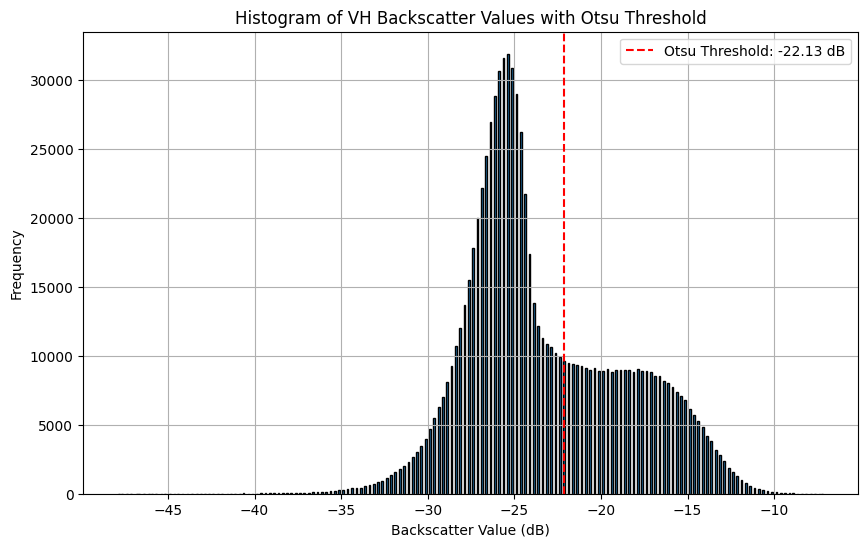

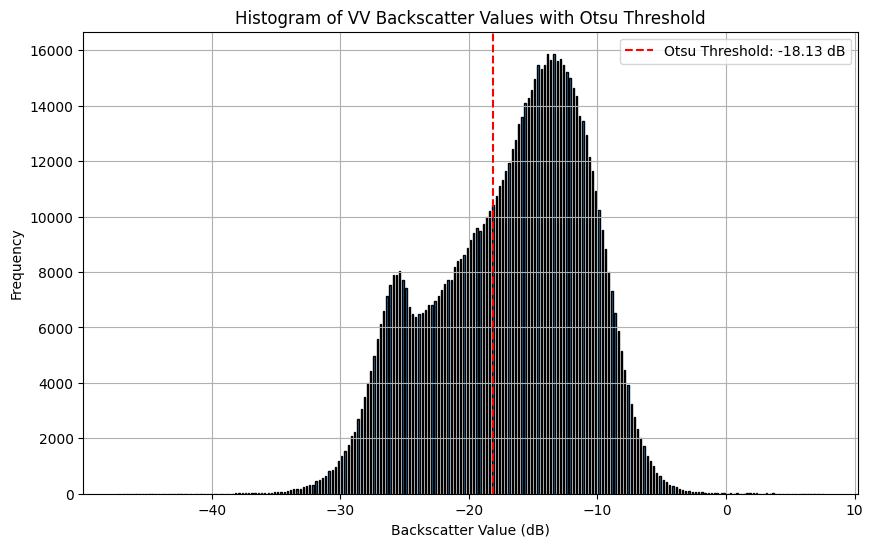

Processing grid cell 2/52
Processing grid cell 3/52
Processing grid cell 4/52
Processing grid cell 5/52
Processing grid cell 6/52
Processing grid cell 7/52
Processing grid cell 8/52
Processing grid cell 9/52
Processing grid cell 10/52
Processing grid cell 11/52
Processing grid cell 12/52
Processing grid cell 13/52


KeyboardInterrupt: 

In [ ]:
#@title Codes 1
import datetime
from datetime import datetime, timedelta
import itertools
import json
from shapely.wkt import loads
import ee
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import numpy as np

# Initialize Earth Engine (Make sure to authenticate first)
# ee.Initialize()

def date_processing(start_date_str, end_date_str, interval_days=5, before_period_days=10):
    """
    Process date ranges for flood detection.
    """
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

    before_start_date = start_date.strftime("%Y-%m-%d")
    before_end_date = (start_date + timedelta(days=before_period_days)).strftime("%Y-%m-%d")

    after_dates = []
    current_date = datetime.strptime(before_end_date, "%Y-%m-%d")
    while current_date <= end_date:
        after_end_date = (current_date + timedelta(days=interval_days)).strftime("%Y-%m-%d")
        after_dates.append((current_date.strftime("%Y-%m-%d"), after_end_date))
        current_date += timedelta(days=interval_days)

    return before_start_date, before_end_date, after_dates

def compute_otsu_threshold(image, band, region, plot_histogram=False):
    """
    Compute Otsu's threshold for an image band over a specified region.
    If plot_histogram is True, plot the histogram and threshold.
    """
    # Compute the histogram
    histogram = image.select(band).reduceRegion(
        reducer=ee.Reducer.histogram(maxBuckets=256),
        geometry=region,
        scale=10,
        bestEffort=True,
        maxPixels=1e13
    ).get(band)

    histogram = ee.Dictionary(histogram)
    counts = ee.Array(histogram.get('histogram'))
    means = ee.Array(histogram.get('bucketMeans'))
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum_total = counts.multiply(means).reduce(ee.Reducer.sum(), [0]).get([0])
    mean = sum_total.divide(total)
    size = counts.length().get([0])

    def bss_fn(i):
        i = ee.Number(i).toInt()
        # Slice arrays using integer indices
        counts1 = counts.slice(0, 0, i)
        counts2 = counts.slice(0, i, size)
        means1 = means.slice(0, 0, i)
        means2 = means.slice(0, i, size)

        w1 = counts1.reduce(ee.Reducer.sum(), [0]).get([0])
        w2 = counts2.reduce(ee.Reducer.sum(), [0]).get([0])

        m1 = counts1.multiply(means1).reduce(ee.Reducer.sum(), [0]).get([0]).divide(w1)
        m2 = counts2.multiply(means2).reduce(ee.Reducer.sum(), [0]).get([0]).divide(w2)

        bss = w1.multiply(w2).multiply(ee.Number(m1).subtract(m2).pow(2))
        return bss

    indices = ee.List.sequence(1, size.subtract(1))
    bss_list = indices.map(bss_fn)
    bss_array = ee.Array(bss_list)
    max_bss = bss_array.reduce(ee.Reducer.max(), [0]).get([0])

    # Convert bss_array to a list for indexOf
    bss_list_numbers = bss_array.toList()
    threshold_index = bss_list_numbers.indexOf(max_bss)
    threshold_index = ee.Number(threshold_index).toInt()

    # Get the threshold from means using a list index
    threshold = means.get([threshold_index])

    # Plot histogram if requested
    if plot_histogram:
        # Retrieve histogram data to client side
        counts_list = counts.getInfo()
        means_list = means.getInfo()
        threshold_value = threshold.getInfo()

        # Plot histogram
        plt.figure(figsize=(10, 6))
        plt.bar(means_list, counts_list, width=0.1, align='center', edgecolor='black')
        plt.axvline(x=threshold_value, color='red', linestyle='--', label=f'Otsu Threshold: {threshold_value:.2f} dB')
        plt.xlabel('Backscatter Value (dB)')
        plt.ylabel('Frequency')
        plt.title(f'Histogram of {band} Backscatter Values with Otsu Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()

    return threshold


def calculate_flood_area(start_date, end_date, geometry, plot_histogram=False):
    """
    Calculate flooded areas using Otsu's method and assign DOY to detected flooding.
    """
    aoi = geometry

    # Process date ranges
    before_start_date, before_end_date, after_dates = date_processing(start_date, end_date)

    # Load and filter Sentinel-1 ImageCollection
    s1_collection = ee.ImageCollection("COPERNICUS/S1_GRD") \
        .filterBounds(aoi) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .filter(ee.Filter.eq('resolution_meters', 10)) \
        .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
        .map(lambda image: image.clip(aoi))

    # Select both VH and VV polarizations
    before_collection = s1_collection.filterDate(before_start_date, before_end_date).select(['VH', 'VV'])
    after_collection = s1_collection.filterDate(start_date, end_date).select(['VH', 'VV'])

    # Compute the median image for the 'before' period
    before_image = before_collection.median()

    # Initialize lists to hold results
    flood_mask_list_vh = []
    flood_mask_list_vv = []

    # Flag to control plotting (only plot for the first image)
    plot_done = False

    # Loop over each after date range
    for after_start_date, after_end_date in after_dates:
        # Filter the 'after' collection for the current date range
        after_collection_filtered = after_collection.filterDate(after_start_date, after_end_date)
        after_image = after_collection_filtered.median()

        # Check if the after_image has data
        if after_image.bandNames().size().getInfo() == 0:
            continue

        # Compute Otsu's threshold for 'VH' and 'VV'
        otsu_threshold_vh = compute_otsu_threshold(after_image, 'VH', aoi, plot_histogram=plot_histogram and not plot_done)
        otsu_threshold_vv = compute_otsu_threshold(after_image, 'VV', aoi, plot_histogram=plot_histogram and not plot_done)

        # Set plot_done to True after plotting once
        if plot_histogram and not plot_done:
            plot_done = True

        # Detect flooded areas based on Otsu's threshold
        flooded_areas_vh = after_image.select('VH').lt(otsu_threshold_vh)
        flooded_areas_vv = after_image.select('VV').lt(otsu_threshold_vv)

        # Apply additional masks
        swater = ee.Image('JRC/GSW1_4/GlobalSurfaceWater')
        swater_mask = swater.select('transition').neq(8)

        dataset = ee.ImageCollection("ESA/WorldCover/v200").first()
        classification = dataset.select('Map').clip(aoi)
        cropland = classification.eq(40)

        # Combine masks for both VH and VV
        flooded_mask_vh = flooded_areas_vh.updateMask(swater_mask).updateMask(cropland)
        flooded_mask_vv = flooded_areas_vv.updateMask(swater_mask).updateMask(cropland)

        # Get the DOY for labeling
        date = ee.Date(after_start_date)
        doy = date.getRelative('day', 'year')

        # Set the pixel values in the flood masks to the DOY
        flooded_mask_vh_doy = flooded_mask_vh.multiply(doy).rename('VH')
        flooded_mask_vv_doy = flooded_mask_vv.multiply(doy).rename('VV')

        # Append the flood masks to the list
        flood_mask_list_vh.append(flooded_mask_vh_doy)
        flood_mask_list_vv.append(flooded_mask_vv_doy)

    # Create an image collection from the flood masks
    flood_masks_collection_vh = ee.ImageCollection(flood_mask_list_vh)
    flood_masks_collection_vv = ee.ImageCollection(flood_mask_list_vv)

    # For VH and VV separately, compute the earliest DOY when flooding was detected
    earliest_flood_vh = flood_masks_collection_vh.min()
    earliest_flood_vv = flood_masks_collection_vv.min()

    return {
        'earliest_flood_vh': earliest_flood_vh,
        'earliest_flood_vv': earliest_flood_vv
    }

# Asset definitions (Make sure these assets are correctly defined in your GEE account)
grid = ee.FeatureCollection("projects/ee-janet/assets/senegal/52_grid_dagana")
init_dagana = ee.FeatureCollection("projects/ee-janet/assets/senegal/updated_dagana_region")
exclusion_area = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_exclusion_region")
protected_areas = ee.FeatureCollection("WCMC/WDPA/current/polygons").filterBounds(init_dagana)
dagana = init_dagana.geometry().difference(exclusion_area.geometry()).difference(protected_areas.geometry())

# Read the grid GeoJSON file into a GeoDataFrame
grid_path = '/content/drive/MyDrive/Remote_sensing/SRV_flooding_detection_models/Dagana/geojson_files/dagana_52_grids/grid52_dagana.geojson'
geogrid = gpd.read_file(grid_path)
df = geogrid.copy()

# Initialize variables to collect the earliest flood images
earliest_flood_vh_list = []
earliest_flood_vv_list = []

# Set plot_histogram to True to plot histogram for one image
plot_histogram = True

# Iterate through the GeoDataFrame to process flood area data for each grid cell
for index, row in df.iterrows():
    print(f'Processing grid cell {index + 1}/{len(df)}')

    # Convert the geometry to Earth Engine format
    geometry_mapping = mapping(row['geometry'])
    ee_geometry = ee.Geometry(geometry_mapping)

    # Calculate flood area and get flood masks
    flood_results = calculate_flood_area(
        start_date="2023-01-03",
        end_date="2023-07-31",
        geometry=ee_geometry,
        plot_histogram=plot_histogram
    )

    # After plotting once, set plot_histogram to False
    if plot_histogram:
        plot_histogram = False

    # Collect the earliest flood images
    earliest_flood_vh = flood_results['earliest_flood_vh']
    earliest_flood_vv = flood_results['earliest_flood_vv']

    # Append to the lists
    earliest_flood_vh_list.append(earliest_flood_vh)
    earliest_flood_vv_list.append(earliest_flood_vv)

# Mosaic the earliest flood images for all grid cells
earliest_flood_vh_mosaic = ee.ImageCollection(earliest_flood_vh_list).mosaic().clip(dagana)
earliest_flood_vv_mosaic = ee.ImageCollection(earliest_flood_vv_list).mosaic().clip(dagana)

# Export the earliest flood images as GeoTIFFs
export_task_vh = ee.batch.Export.image.toDrive(
    image=earliest_flood_vh_mosaic,
    description='earliest_flooding_map_2023_vh',
    folder='EarthEngineExports',
    fileNamePrefix='new_earliest_flooding_map_2023_vh',
    region=dagana,
    scale=10,
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)
export_task_vh.start()

export_task_vv = ee.batch.Export.image.toDrive(
    image=earliest_flood_vv_mosaic,
    description='new_earliest_flooding_map_2023_vv',
    folder='EarthEngineExports',
    fileNamePrefix='earliest_flooding_map_2023_vv',
    region=dagana,
    scale=10,
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)
export_task_vv.start()

print("Processing complete. Export tasks started for the earliest flooding maps.")


In [ ]:
import datetime
from datetime import datetime, timedelta
import itertools
import json
from shapely.wkt import loads
import ee
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import numpy as np
import csv

# Initialize Earth Engine (Make sure to authenticate first)
# ee.Authenticate()
ee.Initialize()

def date_processing(start_date_str, end_date_str, interval_days=5, before_period_days=10):
    """
    Process date ranges for flood detection.
    """
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

    before_start_date = start_date.strftime("%Y-%m-%d")
    before_end_date = (start_date + timedelta(days=before_period_days)).strftime("%Y-%m-%d")

    after_dates = []
    current_date = datetime.strptime(before_end_date, "%Y-%m-%d")
    while current_date <= end_date:
        after_end_date = (current_date + timedelta(days=interval_days)).strftime("%Y-%m-%d")
        after_dates.append((current_date.strftime("%Y-%m-%d"), after_end_date))
        current_date += timedelta(days=interval_days)

    return before_start_date, before_end_date, after_dates

def compute_otsu_threshold(image, band, region, plot_histogram=False):
    """
    Compute Otsu's threshold for an image band over a specified region.
    If plot_histogram is True, plot the histogram and threshold.
    """
    # Compute the histogram
    histogram = image.select(band).reduceRegion(
        reducer=ee.Reducer.histogram(maxBuckets=256),
        geometry=region,
        scale=10,
        bestEffort=True,
        maxPixels=1e13
    ).get(band)

    histogram = ee.Dictionary(histogram)
    counts = ee.Array(histogram.get('histogram'))
    means = ee.Array(histogram.get('bucketMeans'))
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum_total = counts.multiply(means).reduce(ee.Reducer.sum(), [0]).get([0])
    mean = sum_total.divide(total)
    size = counts.length().get([0])

    def bss_fn(i):
        i = ee.Number(i).toInt()
        # Slice arrays using integer indices
        counts1 = counts.slice(0, 0, i)
        counts2 = counts.slice(0, i, size)
        means1 = means.slice(0, 0, i)
        means2 = means.slice(0, i, size)

        w1 = counts1.reduce(ee.Reducer.sum(), [0]).get([0])
        w2 = counts2.reduce(ee.Reducer.sum(), [0]).get([0])

        m1 = counts1.multiply(means1).reduce(ee.Reducer.sum(), [0]).get([0]).divide(w1)
        m2 = counts2.multiply(means2).reduce(ee.Reducer.sum(), [0]).get([0]).divide(w2)

        bss = w1.multiply(w2).multiply(ee.Number(m1).subtract(m2).pow(2))
        return bss

    indices = ee.List.sequence(1, size.subtract(1))
    bss_list = indices.map(bss_fn)
    bss_array = ee.Array(bss_list)
    max_bss = bss_array.reduce(ee.Reducer.max(), [0]).get([0])

    bss_list_numbers = bss_array.toList()
    threshold_index = bss_list_numbers.indexOf(max_bss)
    threshold_index = ee.Number(threshold_index).toInt()
    threshold = means.get([threshold_index])

    # Plot histogram if requested
    if plot_histogram:
        counts_list = counts.getInfo()
        means_list = means.getInfo()
        threshold_value = threshold.getInfo()
        plt.figure(figsize=(10, 6))
        plt.bar(means_list, counts_list, width=0.1, align='center', edgecolor='black')
        plt.axvline(x=threshold_value, color='red', linestyle='--', label=f'Otsu Threshold: {threshold_value:.2f} dB')
        plt.xlabel('Backscatter Value (dB)')
        plt.ylabel('Frequency')
        plt.title(f'Histogram of {band} Backscatter Values with Otsu Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()

    return threshold

def calculate_flood_area(start_date, end_date, geometry, plot_histogram=False):
    try:
        aoi = geometry
        before_start_date, before_end_date, after_dates = date_processing(start_date, end_date)
        s1_collection = ee.ImageCollection("COPERNICUS/S1_GRD") \
            .filterBounds(aoi) \
            .filter(ee.Filter.eq('instrumentMode', 'IW')) \
            .filter(ee.Filter.eq('resolution_meters', 10)) \
            .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
            .map(lambda image: image.clip(aoi))

        before_collection = s1_collection.filterDate(before_start_date, before_end_date).select(['VH', 'VV'])
        after_collection = s1_collection.filterDate(start_date, end_date).select(['VH', 'VV'])

        # Compute the median image for the 'before' period
        before_image = before_collection.median()
        if before_image.bandNames().size().getInfo() == 0:
            print(f"No data available for before period: {before_start_date} to {before_end_date}")
            return None

        flood_mask_list_vh = []
        flood_mask_list_vv = []

        for after_start_date, after_end_date in after_dates:
            after_collection_filtered = after_collection.filterDate(after_start_date, after_end_date)
            after_image = after_collection_filtered.median()

            if after_image.bandNames().size().getInfo() == 0:
                print(f"No data available for after period: {after_start_date} to {after_end_date}")
                continue

            # Use a placeholder threshold for debugging
            otsu_threshold_vh = -16
            otsu_threshold_vv = -15

            flooded_areas_vh = after_image.select('VH').lt(otsu_threshold_vh)
            flooded_areas_vv = after_image.select('VV').lt(otsu_threshold_vv)
            flooded_mask_vh = flooded_areas_vh
            flooded_mask_vv = flooded_areas_vv

            date = ee.Date(after_start_date)
            doy = date.getRelative('day', 'year')

            flooded_mask_vh_doy = flooded_mask_vh.multiply(doy).rename('VH')
            flooded_mask_vv_doy = flooded_mask_vv.multiply(doy).rename('VV')

            flood_mask_list_vh.append(flooded_mask_vh_doy)
            flood_mask_list_vv.append(flooded_mask_vv_doy)

        if not flood_mask_list_vh or not flood_mask_list_vv:
            print(f"No flood masks generated for the given geometry.")
            return None

        flood_masks_collection_vh = ee.ImageCollection(flood_mask_list_vh)
        flood_masks_collection_vv = ee.ImageCollection(flood_mask_list_vv)
        earliest_flood_vh = flood_masks_collection_vh.mosaic()
        earliest_flood_vv = flood_masks_collection_vv.mosaic()

        return {
            'earliest_flood_vh': earliest_flood_vh,
            'earliest_flood_vv': earliest_flood_vv
        }

    except Exception as e:
        print(f"Error in calculate_flood_area: {e}")
        return None


def calculate_cumulative_flooded_area(earliest_flood_image, grid_cell_geometry, scale=10):
    """
    Calculate cumulative flooded area for a given grid cell.
    """
    flood_area_stats = earliest_flood_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=grid_cell_geometry,
        scale=scale,
        maxPixels=1e13
    )
    return flood_area_stats

# Asset definitions
grid = ee.FeatureCollection("projects/ee-janet/assets/senegal/52_grid_dagana")
init_dagana = ee.FeatureCollection("projects/ee-janet/assets/senegal/updated_dagana_region")
exclusion_area = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_exclusion_region")
protected_areas = ee.FeatureCollection("WCMC/WDPA/current/polygons").filterBounds(init_dagana)
dagana = init_dagana.geometry().difference(exclusion_area.geometry()).difference(protected_areas.geometry())

# Read the grid GeoJSON file
grid_path = '/content/drive/MyDrive/Remote_sensing/SRV_flooding_detection_models/Dagana/geojson_files/dagana_52_grids/grid52_dagana.geojson'
geogrid = gpd.read_file(grid_path)
df = geogrid.copy()

# Initialize lists to store results
earliest_flood_vh_list = []
earliest_flood_vv_list = []
cumulative_flooded_data = []

# Process each grid cell
for index, row in df.iterrows():
    print(f'Processing grid cell {index + 1}/{len(df)}')
    geometry_mapping = mapping(row['geometry'])
    ee_geometry = ee.Geometry(geometry_mapping)
    flood_results = calculate_flood_area("2023-01-07", "2023-07-31", ee_geometry, plot_histogram=False)
    vh_flood_area = calculate_cumulative_flooded_area(flood_results['earliest_flood_vh'], ee_geometry)
    vv_flood_area = calculate_cumulative_flooded_area(flood_results['earliest_flood_vv'], ee_geometry)
    cumulative_flooded_data.append({
        'grid_cell_id': index + 1,
        'VH_cumulative_flooded_area': vh_flood_area.get('VH', 0),
        'VV_cumulative_flooded_area': vv_flood_area.get('VV', 0)
    })

# Export cumulative flooded areas to CSV
output_csv_path = '/content/drive/MyDrive/Remote_sensing/SRV_flooding_detection_models/Sentinel_1/current_work/flooded_areas_cumulative.csv'
with open(output_csv_path, mode='w', newline='') as csv_file:
    fieldnames = ['grid_cell_id', 'VH_cumulative_flooded_area', 'VV_cumulative_flooded_area']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(cumulative_flooded_data)

print(f"Cumulative flooded areas saved to {output_csv_path}.")


# **Automated Flood Mapping Using Sentinel 1**


In [ ]:

def date_processing(start_date, end_date, interval_days=5):
    """
    Process date ranges for flood detection.

    Args:
        start_date (str): Start date in "YYYY-MM-DD" format.
        end_date (str): End date in "YYYY-MM-DD" format.
        interval_days (int, optional): Interval between date ranges in days. Default is 5.

    Returns:
        list: List of tuples containing processed date ranges.
    """
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")

    before_start_date = start_date.strftime("%Y-%m-%d")
    before_end_date = (start_date + timedelta(days=10)).strftime("%Y-%m-%d")

    after_dates = []
    current_date = datetime.strptime(before_end_date, "%Y-%m-%d")
    while current_date <= end_date:
        after_end_date = (current_date + timedelta(days=interval_days)).strftime("%Y-%m-%d")
        tuple_dates = (current_date.strftime("%Y-%m-%d"), after_end_date)
        after_dates.append(tuple_dates)
        current_date += timedelta(days=interval_days)

    return [before_start_date, before_end_date, after_dates]


def get_formatted_dates(image_collection):
    """
    Get formatted dates from an image collection.

    Args:
        image_collection (ee.ImageCollection): Earth Engine image collection.

    Returns:
        list: List of formatted date strings.
    """
    dates_list = image_collection.aggregate_array('system:time_start').getInfo()
    return [datetime.fromtimestamp(date/1000).strftime('%Y-%m-%d') for date in dates_list]

def addRatioBand(image):
    """
    Add a ratio band to an image.

    Args:
        image (ee.Image): Input image.

    Returns:
        ee.Image: Image with added ratio band.
    """
    vv_band = image.select('VV')
    vh_band = image.select('VH')
    ratio_band = vv_band.subtract(vh_band).rename('VV/VH')
    selected_image = image.select(['VV', 'VH']).addBands(ratio_band)
    return selected_image

list_flood_masks=[]

def calculate_flood_area(start_date, end_date, year, operation, geometry,polarization='VV', difference_threshold=1.3):
    """
    Calculate flooded area based on Sentinel-1 SAR imagery.

    Args:
        start_date (str): Start date in "YYYY-MM-DD" format.
        end_date (str): End date in "YYYY-MM-DD" format.
        year (str): Year of analysis.
        operation (str): Operation type (e.g., 'flooding').
        asset_path (str): Earth Engine asset path.
        geometry (ee.Geometry): AOI geometry.
        polarization (str, optional): Polarization mode. Default is 'VV'.
        difference_threshold (int, optional): Difference threshold for flood detection. Default is -3.

    Returns:
        dict: Dictionary containing dates and corresponding flood areas.
    """
    aoi = dagana#ee.FeatureCollection(asset_path).geometry()

    input_dates = date_processing(start_date, end_date, interval_days=5)
    before_start_date, before_end_date, after_dates = input_dates



    s1 = ee.ImageCollection("COPERNICUS/S1_GRD") \
        .filterBounds(aoi) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .filter(ee.Filter.Or(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'), ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
        .map(lambda image: image.clip(aoi))

    if polarization == 'VV/VH':
        s1_vv = s1.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')).select('VV')
        s1_vh = s1.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')).select('VH')
        before_image = (s1_vv.filterDate(before_start_date, before_end_date).mosaic().subtract(s1_vh.filterDate(before_start_date, before_end_date).mosaic()))
        after_images = [s1_vv.filterDate(start_date, end_date).mosaic().subtract(s1_vh.filterDate(start_date, end_date).mosaic()) for start_date, end_date in after_dates if s1.filterDate(start_date, end_date).mosaic().bandNames().getInfo() != []]

    elif polarization == 'VV' or polarization == 'VH':
        s1 = s1.select(polarization)
        before_image = s1.filterDate(before_start_date, before_end_date).mosaic()
        after_images = [s1.filterDate(start_date, end_date).mosaic() for start_date, end_date in after_dates if s1.filterDate(start_date, end_date).mosaic().bandNames().getInfo() != []]

    elif polarization == 'rgb':
        before_image = addRatioBand(s1.filterDate(before_start_date, before_end_date).mosaic())
        after_images = [addRatioBand(s1.filterDate(start_date, end_date).mosaic()) for start_date, end_date in after_dates if s1.filterDate(start_date, end_date).mosaic().bandNames().getInfo() != []]

    boxcar = ee.Kernel.square(radius=2, units='pixels', normalize=True)
    before_smoothed = before_image.convolve(boxcar).focal_median(30, 'circle', 'meters')
    after_smoothed_images = [image.convolve(boxcar).focal_median(30, 'circle', 'meters') for image in after_images]




    after_image_dates = [get_formatted_dates(s1.filterDate(start_date, end_date)) for start_date, end_date in after_dates]
    flat_dates_list = list(itertools.chain.from_iterable(after_image_dates))
    unique_dates_set = set(flat_dates_list)
    after_unique_dates_list = list(unique_dates_set)
    after_unique_dates_list.sort()

    swater = ee.Image('JRC/GSW1_4/GlobalSurfaceWater')
    swater_mask = swater.select('transition').neq(8)


    dataset = ee.ImageCollection("ESA/WorldCover/v200").first()
    classification = dataset.select('Map').clip(aoi)
    cropland = classification.eq(40)
    cropland_mask = cropland.eq(40)

    DEM = ee.Image('WWF/HydroSHEDS/03VFDEM')
    terrain = ee.Algorithms.Terrain(DEM)
    slope = terrain.select('slope')
    slopeThreshold = 5
    steepAreas = slope.gt(slopeThreshold)
    slopeMask = steepAreas.Not()

    list_flood_area = []
    j=0


    cumulative=0
    for i, image in enumerate(after_smoothed_images):
        j+=1
        print('LOOP ' + str(j))
        difference = image.divide(before_smoothed)

        # difference = image.subtract(before_smoothed)
        difference_binary = difference.gt(difference_threshold).rename(polarization).selfMask()

        flooded_mask_permanent_water = difference_binary.updateMask(swater_mask)

        flooded_mask_slope = flooded_mask_permanent_water.updateMask(slopeMask)

        connectedPixelThreshold = 8
        connections = flooded_mask_slope.connectedPixelCount(25)
        disconnectedAreas = connections.lt(connectedPixelThreshold)
        disconnectedAreasMask = disconnectedAreas.Not()
        flooded_mask_disconnectedAreasMask = flooded_mask_slope.updateMask(disconnectedAreasMask)

        flooded_mask_cropland = flooded_mask_disconnectedAreasMask.updateMask(cropland)

        flood_area_dict = flooded_mask_cropland.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=geometry,
            scale=10,
            maxPixels=1e10,
            tileScale=16
        ).getInfo()
        flood_area_ha = ee.Number(flood_area_dict.get(polarization)).divide(10000)
        cumulative+=flood_area_ha.getInfo()
        list_flood_area.append(cumulative)

        list_flood_masks.append(flooded_mask_cropland)
    date_flood_area_dict = dict(zip(after_unique_dates_list, list_flood_area))
    print('date_flood_area_dict',date_flood_area_dict)



    return {'dates': after_unique_dates_list, 'flood_area': list_flood_area}


#assets
# Define the grid and region of interest
grid = ee.FeatureCollection("projects/ee-janet/assets/senegal/52_grid_dagana")
init_dagana = ee.FeatureCollection("projects/ee-janet/assets/senegal/updated_dagana_region")
exclusion_area = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_exclusion_region")
protected_areas = ee.FeatureCollection("WCMC/WDPA/current/polygons").filterBounds(init_dagana)
dagana = init_dagana.geometry().difference(exclusion_area.geometry()).difference(protected_areas.geometry())
grid_path = '/content/drive/MyDrive/Remote_sensing/SRV_flooding_detection_models/Dagana/geojson_files/dagana_52_grids/grid52_dagana.geojson'
geogrid = gpd.read_file(grid_path)
df = geogrid.copy()

i=0
for index, row in df.iterrows():

    #  Iterate through the GeoDataFrame to process flood area data for each grid cell.

    i+=1
    print('DF LOOP '+str(i))
    geometry_geojson = loads(str(row['geometry'])).__geo_interface__
    ee_geometry = ee.Geometry(geometry_geojson)
    #asset_path = 'projects/ee-janet/assets/dagana_area'
    aoi = dagana#ee.FeatureCollection(asset_path).geometry()
    polarization = 'VH'

    flood_area_values = calculate_flood_area("2023-01-03", "2023-05-30", '2023', 'flooding', ee_geometry, polarization)


    dates = flood_area_values['dates']
    flood_area_list = flood_area_values['flood_area']
    print('dates',dates,'flood_area_list',flood_area_list)


    for date, flood_area in zip(dates, flood_area_list):
        df.at[index, date] = flood_area

export_params = {
  'image':ee.ImageCollection(list_flood_masks).mosaic(),
  'description': 'new_final_dagana_map_vh',
  'region': aoi,
  'scale': 10,
  'maxPixels': 1e12,
  'fileFormat': 'GeoTIFF'
}

ee.batch.Export.image.toDrive(**export_params).start()
df.to_csv('/content/drive/MyDrive/SRV_flooding_detection_models/Sentinel_1/final_dagana_dataframe_vh.csv', index=False)

In [ ]:
df

# **map only**

In [ ]:
def date_processing(start_date, end_date, interval_days=5):
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")

    before_start_date = start_date.strftime("%Y-%m-%d")
    before_end_date = (start_date + timedelta(days=10)).strftime("%Y-%m-%d")

    after_dates = []
    current_date = datetime.strptime(before_end_date, "%Y-%m-%d")
    while current_date <= end_date:
        after_end_date = (current_date + timedelta(days=interval_days)).strftime("%Y-%m-%d")
        tuple_dates = (current_date.strftime("%Y-%m-%d"), after_end_date)
        after_dates.append(tuple_dates)
        current_date += timedelta(days=interval_days)

    return [before_start_date, before_end_date, after_dates]

def get_formatted_dates(image_collection):
    dates_list = image_collection.aggregate_array('system:time_start').getInfo()
    return [datetime.fromtimestamp(date/1000).strftime('%Y-%m-%d') for date in dates_list]

def addRatioBand(image):
    vv_band = image.select('VV')
    vh_band = image.select('VH')
    ratio_band = vv_band.subtract(vh_band).rename('VV/VH')
    selected_image = image.select(['VV', 'VH']).addBands(ratio_band)
    return selected_image

list_flood_masks=[]

def calculate_flood_area(start_date, end_date, year, operation, asset_path, geometry, grid_path,polarization='VV', difference_threshold=-3):
    aoi = ee.FeatureCollection(asset_path).geometry()
    geogrid = gpd.read_file(grid_path)
    df = geogrid.copy()

    input_dates = date_processing(start_date, end_date, interval_days=5)
    before_start_date, before_end_date, after_dates = input_dates
    list_of_dates = [(before_start_date, before_end_date)] + after_dates

    s1 = ee.ImageCollection("COPERNICUS/S1_GRD") \
        .filterBounds(aoi) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .filter(ee.Filter.Or(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'), ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
        .map(lambda image: image.clip(aoi))

    if polarization == 'VV/VH':
        s1_vv = s1.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')).select('VV')
        s1_vh = s1.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')).select('VH')
        before_image = (s1_vv.filterDate(before_start_date, before_end_date).mosaic().subtract(s1_vh.filterDate(before_start_date, before_end_date).mosaic()))
        after_images = [s1_vv.filterDate(start_date, end_date).mosaic().subtract(s1_vh.filterDate(start_date, end_date).mosaic()) for start_date, end_date in after_dates if s1.filterDate(start_date, end_date).mosaic().bandNames().getInfo() != []]

    elif polarization == 'VV' or polarization == 'VH':
        s1 = s1.select(polarization)
        before_image = s1.filterDate(before_start_date, before_end_date).mosaic()
        after_images = [s1.filterDate(start_date, end_date).mosaic() for start_date, end_date in after_dates if s1.filterDate(start_date, end_date).mosaic().bandNames().getInfo() != []]

    elif polarization == 'rgb':
        before_image = addRatioBand(s1.filterDate(before_start_date, before_end_date).mosaic())
        after_images = [addRatioBand(s1.filterDate(start_date, end_date).mosaic()) for start_date, end_date in after_dates if s1.filterDate(start_date, end_date).mosaic().bandNames().getInfo() != []]

    boxcar = ee.Kernel.square(radius=2, units='pixels', normalize=True)
    before_smoothed = before_image.convolve(boxcar).focal_median(30, 'circle', 'meters')
    after_smoothed_images = [image.convolve(boxcar).focal_median(30, 'circle', 'meters') for image in after_images]

    before_image_dates = get_formatted_dates(s1.filterDate(before_start_date, before_end_date))
    after_image_dates = [get_formatted_dates(s1.filterDate(start_date, end_date)) for start_date, end_date in after_dates]
    flat_dates_list = list(itertools.chain.from_iterable(after_image_dates))
    unique_dates_set = set(flat_dates_list)
    after_unique_dates_list = list(unique_dates_set)
    after_unique_dates_list.sort()

    list_flood_area = []
    i=0
    cumulative=0
    for (date,image) in zip(after_unique_dates_list, after_smoothed_images):
        i+=1
        print('LOOP '+str(i))
        difference = image.subtract(before_smoothed)
        difference_binary = difference.gt(difference_threshold).rename(polarization).selfMask()
        swater = ee.Image('JRC/GSW1_4/GlobalSurfaceWater')
        swater_mask = swater.select('transition').neq(8)
        # permanentWaterMask =  swater.select('seasonality').gte(5).unmask(0).Not().clip(aoi)
        dataset = ee.ImageCollection("ESA/WorldCover/v200").first()
        classification = dataset.select('Map').clip(aoi)
        # permanent_water_v200 = classification.eq(80).unmask(0).Not()


        flooded_mask_permanent_water = difference_binary.updateMask(swater_mask)

        DEM = ee.Image('WWF/HydroSHEDS/03VFDEM')
        terrain = ee.Algorithms.Terrain(DEM)
        slope = terrain.select('slope')
        slopeThreshold = 5
        steepAreas = slope.gt(slopeThreshold)
        slopeMask = steepAreas.Not()
        flooded_mask_slope = flooded_mask_permanent_water.updateMask(slopeMask)

        connectedPixelThreshold = 8
        connections = flooded_mask_slope.connectedPixelCount(connectedPixelThreshold)
        disconnectedAreas = connections.lt(connectedPixelThreshold)
        disconnectedAreasMask = disconnectedAreas.Not()
        flooded_mask_disconnectedAreasMask = flooded_mask_slope.updateMask(disconnectedAreasMask)


        cropland = classification.eq(40)

        flooded_mask_cropland = flooded_mask_disconnectedAreasMask.updateMask(cropland)
        export_params = {
            'image':flooded_mask_cropland,
            'description': 'image_'+date,
            'folder': 'image_date',
            'region': aoi,
            'scale': 10,
            'maxPixels': 1e12,
            'fileFormat': 'GeoTIFF'
        }
        ee.batch.Export.image.toDrive(**export_params).start()


        # flood_area_dict = flooded_mask_cropland.multiply(ee.Image.pixelArea()).reduceRegion(
        #     reducer=ee.Reducer.sum(),
        #     geometry=geometry,
        #     scale=10,
        #     maxPixels=1e15
        # ).getInfo()
        # flood_area_ha = ee.Number(flood_area_dict.get(polarization)).divide(10000)
        # cumulative+=flood_area_ha.getInfo()
        # list_flood_area.append(cumulative)

        list_flood_masks.append(flooded_mask_cropland)
    date_flood_area_dict = dict(zip(after_unique_dates_list, list_flood_area))



    # return {'dates': after_unique_dates_list, 'flood_area': list_flood_area}


grid_path = '/content/drive/MyDrive/ICRISAT_STAGE-20230704T171037Z-001/ICRISAT_STAGE/automated_flood_mapping_system-main/grid52_dagana_shp/grid52_dagana.geojson'  # Chemin d'accès au fichier GeoJSON des grilles
geogrid = gpd.read_file(grid_path)
df = geogrid.copy()

i=0
# for index, row in df.iterrows():
#     i+=1
#     print('DF LOOP '+str(i))
#     geometry_geojson = loads(str(row['geometry'])).__geo_interface__
#     ee_geometry = ee.Geometry(geometry_geojson)
asset_path = 'projects/ee-rouguib/assets/grid52_dagana'
aoi = ee.FeatureCollection(asset_path).geometry()

grid_path = '/content/drive/MyDrive/ICRISAT_STAGE-20230704T171037Z-001/ICRISAT_STAGE/automated_flood_mapping_system-main/grid52_dagana_shp/grid52_dagana.geojson'  # Chemin d'accès au fichier GeoJSON des grilles
polarization = 'VV'

flood_area_values = calculate_flood_area("2023-01-03", "2023-05-30", '2023', 'flooding', asset_path, ee_geometry, grid_path, polarization)

#     dates = flood_area_values['dates']
#   flood_area_list = flood_area_values['flood_area']
# if export_map==True:
export_params = {
    'image':ee.ImageCollection(list_flood_masks).mosaic(),
    'description': 'subtract_transition_swater_mask',
    'region': aoi,
    'scale': 10,
    'maxPixels': 1e12,
    'fileFormat': 'GeoTIFF'
}

ee.batch.Export.image.toDrive(**export_params).start()

# ee.batch.Export.table.toDrive(**{
#   'collection': ee.FeatureCollection(list_flood_masks),
#   'description': 'dagana_table',
#   'folder': 'earthengine',
#   'fileNamePrefix': 'accuracy',
#   'fileFormat': 'CSV'
# }).start()
# featureCollection=ee.FeatureCollection(list_flood_masks)
# # Visualize the Feature Collection
# Map = geemap.Map()
# Map.centerObject(featureCollection, 12)
# Map.addLayer(featureCollection, {}, "Feature Collection")
# Map

# # Function to convert a feature to an image
# def feature_to_image(feature):
#     geometry = feature.geometry()
#     properties = feature.toDictionary()
#     image = ee.Image.constant(0).clip(geometry).set(properties)
#     return image

# # Map the function over the Feature Collection to create an Image Collection
# imageCollection = featureCollection.map(feature_to_image)

# Map = geemap.Map()
# Map.centerObject(imageCollection, 6)
# Map.addLayer(imageCollection, {}, "Image Collection")
# Map

#     for date, flood_area in zip(dates, flood_area_list):
#         df.at[index, date] = flood_area

# df.to_csv('/content/drive/MyDrive/ICRISAT_STAGE-20230704T171037Z-001/ICRISAT_STAGE/automated_harvest_detection_in_rice-main/result_of_s1_df/dagana_2023_s1_vv_transition.csv', index=False)

Processing grid cell 1/52


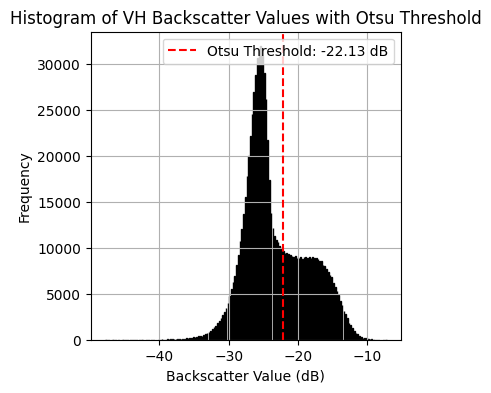

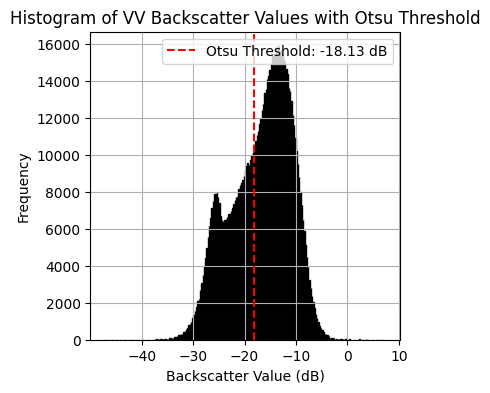

Processing grid cell 2/52
Processing grid cell 3/52
Processing grid cell 4/52
Processing grid cell 5/52
Processing grid cell 6/52
Processing grid cell 7/52
Processing grid cell 8/52
Processing grid cell 9/52
Processing grid cell 10/52
Processing grid cell 11/52
Processing grid cell 12/52
Processing grid cell 13/52
Processing grid cell 14/52
Processing grid cell 15/52
Processing grid cell 16/52
Processing grid cell 17/52
Processing grid cell 18/52
Processing grid cell 19/52
Processing grid cell 20/52
Processing grid cell 21/52
Processing grid cell 22/52
Processing grid cell 23/52
Processing grid cell 24/52
Processing grid cell 25/52
Processing grid cell 26/52
Processing grid cell 27/52
Processing grid cell 28/52
Processing grid cell 29/52
Processing grid cell 30/52
Processing grid cell 31/52
Processing grid cell 32/52
Processing grid cell 33/52
Processing grid cell 34/52
Processing grid cell 35/52
Processing grid cell 36/52
Processing grid cell 37/52
Processing grid cell 38/52
Processin

In [ ]:
#@title Start here
import datetime
from datetime import datetime, timedelta
import itertools
import json
from shapely.wkt import loads
import ee
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import numpy as np

# Initialize Earth Engine (Make sure to authenticate first)
ee.Initialize()

def date_processing(start_date_str, end_date_str, interval_days=5, before_period_days=10):
    """
    Process date ranges for flood detection.
    """
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

    before_start_date = start_date.strftime("%Y-%m-%d")
    before_end_date = (start_date + timedelta(days=before_period_days)).strftime("%Y-%m-%d")

    after_dates = []
    current_date = datetime.strptime(before_end_date, "%Y-%m-%d")
    while current_date <= end_date:
        after_end_date = (current_date + timedelta(days=interval_days)).strftime("%Y-%m-%d")
        after_dates.append((current_date.strftime("%Y-%m-%d"), after_end_date))
        current_date += timedelta(days=interval_days)

    return before_start_date, before_end_date, after_dates

def compute_otsu_threshold(image, band, region, plot_histogram=False):
    """
    Compute Otsu's threshold for an image band over a specified region.
    If plot_histogram is True, plot the histogram and threshold.
    """
    # Compute the histogram
    histogram = image.select(band).reduceRegion(
        reducer=ee.Reducer.histogram(maxBuckets=256),
        geometry=region,
        scale=10,
        bestEffort=True,
        maxPixels=1e13
    ).get(band)

    histogram = ee.Dictionary(histogram)
    counts = ee.Array(histogram.get('histogram'))
    means = ee.Array(histogram.get('bucketMeans'))
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum_total = counts.multiply(means).reduce(ee.Reducer.sum(), [0]).get([0])
    mean = sum_total.divide(total)
    size = counts.length().get([0])

    def bss_fn(i):
        i = ee.Number(i).toInt()
        counts1 = counts.slice(0, 0, i)
        counts2 = counts.slice(0, i, size)
        means1 = means.slice(0, 0, i)
        means2 = means.slice(0, i, size)

        w1 = counts1.reduce(ee.Reducer.sum(), [0]).get([0])
        w2 = counts2.reduce(ee.Reducer.sum(), [0]).get([0])

        m1 = counts1.multiply(means1).reduce(ee.Reducer.sum(), [0]).get([0]).divide(w1)
        m2 = counts2.multiply(means2).reduce(ee.Reducer.sum(), [0]).get([0]).divide(w2)

        bss = w1.multiply(w2).multiply(ee.Number(m1).subtract(m2).pow(2))
        return bss

    indices = ee.List.sequence(1, size.subtract(1))
    bss_list = indices.map(bss_fn)
    bss_array = ee.Array(bss_list)
    max_bss = bss_array.reduce(ee.Reducer.max(), [0]).get([0])

    # Convert bss_array to a list for indexOf
    bss_list_numbers = bss_array.toList()
    threshold_index = bss_list_numbers.indexOf(max_bss)
    threshold_index = ee.Number(threshold_index).toInt()

    # Get the threshold from means using a list index
    threshold = means.get([threshold_index])

    # Plot histogram if requested
    if plot_histogram:
        # Retrieve histogram data to client side
        counts_list = counts.getInfo()
        means_list = means.getInfo()
        threshold_value = threshold.getInfo()

        # Plot histogram
        plt.figure(figsize=(4, 4))
        plt.bar(means_list, counts_list, width=0.1, align='center', edgecolor='black')
        plt.axvline(x=threshold_value, color='red', linestyle='--', label=f'Otsu Threshold: {threshold_value:.2f} dB')
        plt.xlabel('Backscatter Value (dB)')
        plt.ylabel('Frequency')
        plt.title(f'Histogram of {band} Backscatter Values with Otsu Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()

    return threshold

def calculate_flood_area(start_date, end_date, geometry, plot_histogram=False):
    """
    Calculate flooded areas using Otsu's method and assign DOY to detected flooding.
    Also, calculate flooded area in hectares and return values for DataFrame update.
    """
    aoi = geometry

    # Process date ranges
    before_start_date, before_end_date, after_dates = date_processing(start_date, end_date)

    # Load and filter Sentinel-1 ImageCollection
    s1_collection = ee.ImageCollection("COPERNICUS/S1_GRD") \
        .filterBounds(aoi) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .filter(ee.Filter.eq('resolution_meters', 10)) \
        .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
        .map(lambda image: image.clip(aoi))

    # Select both VH and VV polarizations
    before_collection = s1_collection.filterDate(before_start_date, before_end_date).select(['VH', 'VV'])
    after_collection = s1_collection.filterDate(start_date, end_date).select(['VH', 'VV'])

    # Compute the median image for the 'before' period
    before_image = before_collection.median()

    # Initialize lists to hold results
    flood_mask_list_vh = []
    flood_mask_list_vv = []
    dates_list = []
    flood_area_vh_list = []
    flood_area_vv_list = []

    # Flag to control plotting (only plot for the first image)
    plot_done = False

    # Loop over each after date range
    for after_start_date, after_end_date in after_dates:
        # Filter the 'after' collection for the current date range
        after_collection_filtered = after_collection.filterDate(after_start_date, after_end_date)
        after_image = after_collection_filtered.median()

        # Check if the after_image has data
        if after_image.bandNames().size().getInfo() == 0:
            continue

        # Compute Otsu's threshold for 'VH' and 'VV'
        otsu_threshold_vh = compute_otsu_threshold(after_image, 'VH', aoi, plot_histogram=plot_histogram and not plot_done)
        otsu_threshold_vv = compute_otsu_threshold(after_image, 'VV', aoi, plot_histogram=plot_histogram and not plot_done)

        # Set plot_done to True after plotting once
        if plot_histogram and not plot_done:
            plot_done = True

        # Detect flooded areas based on Otsu's threshold
        flooded_areas_vh = after_image.select('VH').lt(otsu_threshold_vh)
        flooded_areas_vv = after_image.select('VV').lt(otsu_threshold_vv)

        # Apply additional masks
        swater = ee.Image('JRC/GSW1_4/GlobalSurfaceWater')
        swater_mask = swater.select('transition').neq(8)

        dataset = ee.ImageCollection("ESA/WorldCover/v200").first()
        classification = dataset.select('Map').clip(aoi)
        cropland = classification.eq(40)

        # Combine masks for both VH and VV
        flooded_mask_vh = flooded_areas_vh.updateMask(swater_mask).updateMask(cropland)
        flooded_mask_vv = flooded_areas_vv.updateMask(swater_mask).updateMask(cropland)

        # Get the DOY for labeling
        date = ee.Date(after_start_date)
        doy = date.getRelative('day', 'year')

        # Set the pixel values in the flood masks to the DOY
        flooded_mask_vh_doy = flooded_mask_vh.multiply(doy).rename('VH')
        flooded_mask_vv_doy = flooded_mask_vv.multiply(doy).rename('VV')

        # Append the flood masks to the list
        flood_mask_list_vh.append(flooded_mask_vh_doy)
        flood_mask_list_vv.append(flooded_mask_vv_doy)

        # Calculate the flooded area in hectares for both VH and VV
        flood_area_vh = flooded_mask_vh.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=aoi,
            scale=10,
            maxPixels=1e10
        ).get('VH')

        flood_area_vv = flooded_mask_vv.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=aoi,
            scale=10,
            maxPixels=1e10
        ).get('VV')

        flood_area_vh_ha = ee.Number(flood_area_vh).divide(10000)
        flood_area_vv_ha = ee.Number(flood_area_vv).divide(10000)

        # Append results to lists
        dates_list.append(after_start_date)
        flood_area_vh_list.append(flood_area_vh_ha.getInfo() if flood_area_vh_ha else 0)
        flood_area_vv_list.append(flood_area_vv_ha.getInfo() if flood_area_vv_ha else 0)

    # Create an image collection from the flood masks
    flood_masks_collection_vh = ee.ImageCollection(flood_mask_list_vh)
    flood_masks_collection_vv = ee.ImageCollection(flood_mask_list_vv)

    # For VH and VV separately, compute the earliest DOY when flooding was detected
    earliest_flood_vh = flood_masks_collection_vh.min()
    earliest_flood_vv = flood_masks_collection_vv.min()

    # Return the results and the flood masks
    return {
        'dates': dates_list,
        'flood_area_vh': flood_area_vh_list,
        'flood_area_vv': flood_area_vv_list,
        'earliest_flood_vh': earliest_flood_vh,
        'earliest_flood_vv': earliest_flood_vv
    }

# Asset definitions (Make sure these assets are correctly defined in your GEE account)
grid = ee.FeatureCollection("projects/ee-janet/assets/senegal/52_grid_dagana")
init_dagana = ee.FeatureCollection("projects/ee-janet/assets/senegal/updated_dagana_region")
exclusion_area = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_exclusion_region")
protected_areas = ee.FeatureCollection("WCMC/WDPA/current/polygons").filterBounds(init_dagana)
dagana = init_dagana.geometry().difference(exclusion_area.geometry()).difference(protected_areas.geometry())

# Read the grid GeoJSON file into a GeoDataFrame
grid_path = '/content/drive/MyDrive/Remote_sensing/SRV_flooding_detection_models/Dagana/geojson_files/dagana_52_grids/grid52_dagana.geojson'
geogrid = gpd.read_file(grid_path)
df = geogrid.copy()

# Initialize variables to collect the earliest flood images
earliest_flood_vh_list = []
earliest_flood_vv_list = []

# Set plot_histogram to True to plot histogram for one image
plot_histogram = True

# Iterate through the GeoDataFrame to process flood area data for each grid cell
for index, row in df.iterrows():
    print(f'Processing grid cell {index + 1}/{len(df)}')

    # Convert the geometry to Earth Engine format
    geometry_mapping = mapping(row['geometry'])
    ee_geometry = ee.Geometry(geometry_mapping)

    # Calculate flood area and get flood masks
    flood_results = calculate_flood_area(
        start_date="2023-01-07",
        end_date="2023-07-31",
        geometry=ee_geometry,
        plot_histogram=plot_histogram
    )

    # After plotting once, set plot_histogram to False
    if plot_histogram:
        plot_histogram = False

    # Collect the earliest flood images
    earliest_flood_vh = flood_results['earliest_flood_vh']
    earliest_flood_vv = flood_results['earliest_flood_vv']

    # Append to the lists
    earliest_flood_vh_list.append(earliest_flood_vh)
    earliest_flood_vv_list.append(earliest_flood_vv)

    # Update the DataFrame with the flood area results
    dates = flood_results['dates']
    flood_area_vh_list = flood_results['flood_area_vh']
    flood_area_vv_list = flood_results['flood_area_vv']
    for date, flood_area_vh, flood_area_vv in zip(dates, flood_area_vh_list, flood_area_vv_list):
        df.at[index, f'{date}_VH'] = flood_area_vh
        df.at[index, f'{date}_VV'] = flood_area_vv

# Mosaic the earliest flood images for all grid cells
earliest_flood_vh_mosaic = ee.ImageCollection(earliest_flood_vh_list).mosaic().clip(dagana)
earliest_flood_vv_mosaic = ee.ImageCollection(earliest_flood_vv_list).mosaic().clip(dagana)

# Export the earliest flood images as GeoTIFFs
export_task_vh = ee.batch.Export.image.toDrive(
    image=earliest_flood_vh_mosaic,
    description='earliest_flooding_map_2023_vh',
    folder='EarthEngineExports',
    fileNamePrefix='earliest_flooding_map_2023_vh',
    region=dagana,
    scale=10,
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)
export_task_vh.start()

export_task_vv = ee.batch.Export.image.toDrive(
    image=earliest_flood_vv_mosaic,
    description='earliest_flooding_map_2023_vv',
    folder='EarthEngineExports',
    fileNamePrefix='earliest_flooding_map_2023_vv',
    region=dagana,
    scale=10,
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)
export_task_vv.start()

# Save the DataFrame to a CSV file
output_csv_path = '/content/drive/MyDrive/Remote_sensing/SRV_flooding_detection_models/Sentinel_1/current_work/flooded_areas_cumulative_df.csv'
df.to_csv(output_csv_path, index=False)

print("Processing complete. Export tasks started for the earliest flooding maps and results saved to CSV.")


In [ ]:
#@title updating this part
import datetime
from datetime import datetime, timedelta
import itertools
import json
from shapely.wkt import loads
import ee
import geopandas as gpd
from shapely.geometry import mapping
from tqdm import tqdm
from IPython.display import display

# Initialize Earth Engine (Make sure to authenticate first)
ee.Initialize()

# Define the grid and region of interest
grid = ee.FeatureCollection("projects/ee-janet/assets/senegal/52_grid_dagana")
init_dagana = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana")

# Additional layers from OpenStreetMap data
dagana_reservoir = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_reservoir")
dagana_water = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_water")
dagana_riverbanks = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_riverbanks")
dagana_wetland = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_wetland")
exclusion_area = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_exclusion_region")

# Exlude the permanent water areas
exclusion_areas = dagana_riverbanks.geometry() \
    .union(dagana_wetland.geometry()) \
    .union(dagana_reservoir.geometry()) \
    .union(dagana_water.geometry())

# Subtract exclusion areas from the initial Dagana region
dagana = init_dagana.geometry().difference(exclusion_areas)

# Get the bounding box and center of the ROI for the Folium map
roi_bounds = dagana.bounds().getInfo()['coordinates'][0]
center_lat = (roi_bounds[0][1] + roi_bounds[2][1]) / 2
center_lon = (roi_bounds[0][0] + roi_bounds[2][0]) / 2

# Create a map for visualization
m = geemap.Map(center=[center_lat, center_lon], zoom=10)
# Add basemap
m.add_basemap('Esri.WorldImagery')

def _refined_lee_filter(image):
    """
    Apply Refined Lee speckle filter to reduce noise while preserving edges.
    Fixed implementation to properly handle Earth Engine band operations.
    """
    # Parameters
    kernel_size = 7
    kernel_weights = ee.List.repeat(ee.List.repeat(1, kernel_size), kernel_size)
    kernel = ee.Kernel.fixed(kernel_size, kernel_size, kernel_weights)

    # Get the bands to process
    bandNames = ['VV', 'VH']

    def apply_filter_to_band(bandName):
      band = image.select(bandName)

      # Mean and variance
      mean = band.reduceNeighborhood(ee.Reducer.mean(), kernel)
      variance = band.reduceNeighborhood(ee.Reducer.variance(), kernel)

      # Coefficient of variation
      ci = variance.sqrt().divide(mean)

      # Refined Lee filter parameters
      looks = 4
      cu = np.sqrt(1.0/looks)
      cmax = np.sqrt(2.0) * cu

      # Pixel weights
      w1 = ci.lt(cu)  # Homogeneous
      w2 = ci.gt(cmax)  # Heterogeneous
      w3 = ci.gte(cu).And(ci.lte(cmax))  # Mixed

      # Filter result
      filtered = ee.Image.constant(0) \
          .where(w1, mean) \
          .where(w2, band) \
          .where(w3, mean.multiply(0.5).add(band.multiply(0.5)))

      return filtered.rename(bandName)

      # Apply filter to each band separately
      filtered_bands = [apply_filter_to_band(band) for band in bandNames]
      return ee.Image.cat(filtered_bands)

def date_processing(start_date, end_date, interval_days=5): #delete before_period_days=10
    """
    Process date ranges for flood detection.

    Args:
        start_date_str (str): Start date in "YYYY-MM-DD" format.
        end_date_str (str): End date in "YYYY-MM-DD" format.
        interval_days (int): Interval between date ranges in days.
        before_period_days (int): Number of days for the 'before' period.

    Returns:
        tuple: before_start_date, before_end_date, list of after_date tuples.
    """
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    date_list = []
    while start_date <= end_date:
        date_list.append(start_date.strftime("%Y-%m-%d"))
        start_date += timedelta(days=interval_days)
    return date_list

 # Function to calculate flood area for each grid cell
def calculate_grid_flood_area(flood_mask, grid,date):
    def calculate_area(feature):
        area = flood_mask.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=feature.geometry(),
            scale=10,
            maxPixels=1e13
        )
        area_ha = area.getNumber('constant').divide(10000).format('%.2f')
        #return feature.set('flood_area_ha', area_ha)
        return feature.set({'flood_area_ha': area_ha, 'date': date})
    return grid.map(calculate_area)

# Function to get day of year
def get_doy(date_string):
    date = datetime.strptime(date_string, '%Y-%m-%d')
    return date.timetuple().tm_yday

def extract_flood_data(features, date):
    flood_data = []
    for feature in features:
        grid_id = feature['properties']['ID']
        flood_area_ha = feature['properties'].get('flood_area_ha', 0)
        flood_data.append({
            'date': date,
            'grid_id': grid_id,
            'flood_area_ha': flood_area_ha,
            **{k: v for k, v in feature['properties'].items() if k != 'flood_area_ha'}
        })
    return flood_data

def create_flood_dataframe(flood_data):
    df = pd.DataFrame(flood_data)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index(['date', 'grid_id'], inplace=True)
    return df

def process_flood_results(df, grid_properties):
    df['flood_area_ha'] = pd.to_numeric(df['flood_area_ha'], errors='coerce')
    df['flood_area_ha'].fillna(0, inplace=True)
    if isinstance(grid_properties, pd.DataFrame):
        final_df = pd.merge(df.reset_index(), grid_properties, on='grid_id', how='left')
    else:
        final_df = df
    return final_df

def get_unique_dates(image_collection):
    """
    Get unique dates from an image collection.

    Args:
        image_collection (ee.ImageCollection): Earth Engine image collection.

    Returns:
        ee.List: List of unique date strings.
    """
    dates = image_collection.aggregate_array('system:time_start')
    unique_dates = dates.distinct().sort()
    formatted_dates = unique_dates.map(lambda date: ee.Date(date).format('YYYY-MM-dd'))
    return formatted_dates

dataset = ee.Image('JRC/GSW1_4/MonthlyHistory/2021_01').clip(dagana)
# Select water and create a binary mask
water = dataset.select('water').eq(2)
masked = water.updateMask(water)
polarization = "VV"
def process_each_date(aoi, date, polarization):
    start_period = datetime.strptime(date, "%Y-%m-%d") - timedelta(days=5)
    end_period = datetime.strptime(date, "%Y-%m-%d") + timedelta(days=5)
    s1_grd_col = ee.ImageCollection("COPERNICUS/S1_GRD") \
                      .filterBounds(aoi) \
                      .filterDate(start_period, end_period) \
                      .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                      .filter(ee.Filter.eq('resolution_meters', 10)) \
                      .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
                      .filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarization)) \
                     # .filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarization[1])) \
                     # .map(lambda image: image.clip(aoi))

    # Check if the image collection is empty
    if s1_grd_col.size().getInfo() == 0:
        print(f"No images found for date {date} with polarization {polarization}.")
        return None
    def preprocess_image(img):
            """Preprocess single Sentinel-1 image."""
            # Select the bands we need
            img = img.select(polarization)

            # Convert to decibels
            img_db = ee.Image.constant(10).multiply(img.log10())

            # Apply speckle filter
            img_filtered =_refined_lee_filter(img_db, polarization)

            # Calculate indices
            #img_indices = self._calculate_indices(img_filtered)

            # Mask invalid values
            return img_filtered#.updateMask(img_filtered.select(polarization).gt(-50))
    #process the collection
    processed_col = s1_grd_col.map(preprocess_image)
    # Mosaic the images
    composite = processed_col.mosaic()
    composite_ = composite.updateMask(water.Not())
    # Detect flooded areas based on fixed thresholds
    threshold = -22 if polarization == 'VH' else -15  # Adjust thresholds based on polarization -19 and -20
    water_mask = composite_.select(polarization).lt(threshold)
    connected_pixels = water_mask.connectedPixelCount()
    final_mask = water_mask.updateMask(connected_pixels.gt(8))
    return final_mask.clip(dagana)

# Add this new function for exporting images
def export_image(image, description, region, folder):
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        folder=folder,
        scale=10,
        region=region,
        maxPixels=1e13
    )
    task.start()
    print(f"Started export task for {description}")


#get an equivalent s1 image of the aoi to save the cumulative areas
# Load the Sentinel-1 image collection and filter for the AOI
prev_s1_coll = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(dagana) \
    .filterDate('2022-12-01', '2022-12-31')  # Adjust date range as needed

# Get the projection of the VV or VH band
projection = prev_s1_coll.mosaic().clip(dagana).select('VV').projection()

# Function to process and visualize flooding, mapping only at the end of each month
def process_and_visualize_flooding(aoi, date_ranges, grid):
    flood_data = []
    cumulative_flood_mask = ee.Image(0).reproject(crs=projection, scale=10).clip(aoi)
    flood_vis_params = {
        'min': min([get_doy(d) for d in date_ranges]),
        'max': max([get_doy(d) for d in date_ranges]),
        'palette': ['blue', 'cyan', 'green', 'yellow', 'red']
        }

    current_month = None

    # Initialize the progress bar
    for i, date in tqdm(enumerate(date_ranges), total=len(date_ranges), desc="Processing Dates"):
        current_pol_area = process_each_date(aoi, date,polarization)
        if current_pol_area is not None:
            doy = get_doy(date)
            base_date_mask = current_pol_area
            cumulative_flood_mask = cumulative_flood_mask.where(base_date_mask.And(cumulative_flood_mask.eq(0)), doy)
            # Calculate the flood area for the grid at each 5-day interval
            grid_with_flood_area = calculate_grid_flood_area(cumulative_flood_mask.gt(0), grid, date) #.updateMask(cumulative_flood_mask.gt(0))
            flood_data.extend(extract_flood_data(grid_with_flood_area.getInfo()['features'], date))
            # Get the month of the current date
            date_obj = datetime.strptime(date, "%Y-%m-%d")
            if current_month is None:
                current_month = date_obj.month
            # Check if the next date is in a new month or if it's the last date
            is_end_of_month = (i == len(date_ranges) - 1) or (datetime.strptime(date_ranges[i + 1], "%Y-%m-%d").month != current_month)
            if is_end_of_month:
                # Add layer to map
                m.add_layer(cumulative_flood_mask.updateMask(cumulative_flood_mask.gt(0)),
                              flood_vis_params, f'{polarization}_Flooding Progression up to {date}')

                export_folder = "fis_flooding_maps"
                # Export the cumulative flood mask
                export_image(
                    cumulative_flood_mask.updateMask(cumulative_flood_mask.gt(0)),
                    f'{polarization}_Flooding_map_{date}',
                    aoi,
                    export_folder
                )
                # Reset current_month for the next month
                if i != len(date_ranges) - 1:
                    current_month = datetime.strptime(date_ranges[i + 1], "%Y-%m-%d").month
        else:
            print(f"Skipping date {date} due to no valid {polarization}")
    m.add_colorbar(flood_vis_params, label="Day of the year",
                    orientation="horizontal",
                    layer_name="Flooding detection")
    return flood_data

#call the above function
start_date = '2023-01-31'
end_date = '2023-03-03'
date_ranges = date_processing(start_date, end_date)
flood_data = process_and_visualize_flooding(dagana, date_ranges, grid)

#post process the data
df = create_flood_dataframe(flood_data)
df = df.reset_index()
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
# Pivot the table
df_pivoted = df.pivot(index='grid_id', columns='date', values='flood_area_ha')
columns_date = df_pivoted.columns

#estimating the flooding date - this part might change - current research undergoing about the estimation
#of the flooding date
maxValueIndex1 = df_pivoted[columns_date].idxmax(axis=1)
df_pivoted['flooding_date'] = maxValueIndex1

# Restructing the data
columns_to_keep = ['ID', 'LatNP', 'Latitude', 'LonNP', 'Longitude', 'nasapid']
df_other = df.drop_duplicates(subset=['grid_id'])[columns_to_keep + ['grid_id']].set_index('grid_id')
df_pivoted = df_pivoted.rename_axis(index='grid_id')
df_final = df_other.join(df_pivoted)
df_final = df_final.reset_index()
date_columns = [col for col in df_final.columns if col not in columns_to_keep + ['grid_id', 'index']]
df_final = df_final[columns_to_keep + ['grid_id'] + sorted(date_columns)]

#save the dataframe as you wish
year = 2023
output_file_name = f'{polarization}_floodingData_{year}.csv'
df_final.to_csv(output_file_name, index=False)

# Display the map
display(m)

Processing Dates:   0%|          | 0/7 [00:07<?, ?it/s]


TypeError: _refined_lee_filter() takes 1 positional argument but 2 were given

In [ ]:
df_final

In [ ]:
import ee
import numpy as np
from datetime import datetime, timedelta

class EnhancedFloodDetector:
    def __init__(self):
        """Initialize the enhanced flood detector with improved preprocessing."""
        ee.Initialize()

    def _refined_lee_filter(self, image):
        """
        Apply Refined Lee speckle filter to reduce noise while preserving edges.
        This implementation follows the algorithm described in:
        Lee, J.-S., et al. (1999), Improved Sigma Filter for Speckle Filtering of SAR Imagery
        """
        def apply_filter(band):
            # Parameters for refined Lee filter
            kernel_size = 7
            looks = 4
            damping_factor = 1

            # Create kernels for directional gradients
            weights = ee.List.repeat(ee.List.repeat(1, kernel_size), kernel_size)
            kernel = ee.Kernel.fixed(kernel_size, kernel_size, weights)

            # Calculate mean and variance
            mean = band.reduceNeighborhood(ee.Reducer.mean(), kernel)
            variance = band.reduceNeighborhood(ee.Reducer.variance(), kernel)

            # Calculate coefficient of variation
            ci = variance.sqrt().divide(mean)

            # Refined Lee filter weights
            cu = np.sqrt(1.0/looks)
            cmax = np.sqrt(2.0) * cu

            # Calculate weights for different pixel classes
            w1 = ci.lt(cu)  # Homogeneous pixels
            w2 = ci.gt(cmax)  # Heterogeneous pixels
            w3 = ci.gte(cu).And(ci.lte(cmax))  # Mixed pixels

            # Apply filter based on pixel class
            refined = ee.Image.constant(0).where(
                w1, mean).where(
                w2, band).where(
                w3, mean.multiply(damping_factor).add(
                    band.multiply(ee.Image.constant(1).subtract(damping_factor))))

            return refined

        # Apply filter to each band
        bands = image.bandNames()
        filtered_bands = bands.map(lambda b: apply_filter(image.select([b])))

        return ee.Image.cat(filtered_bands)

    def _calculate_indices(self, image):
        """
        Calculate advanced polarization indices for better water detection.
        """
        vv = image.select('VV')
        vh = image.select('VH')

        # Normalized Difference Polarization Index (NDPI)
        ndpi = vv.subtract(vh).divide(vv.add(vh)).rename('NDPI')

        # Normalized Difference Ratio Index (NDRI)
        # NDRI = (VV - VH) / (VV + VH + c), where c is a small constant to avoid division by zero
        c = ee.Image.constant(0.0001)
        ndri = vv.subtract(vh).divide(vv.add(vh).add(c)).rename('NDRI')

        # Cross-polarization ratio
        cpr = vh.divide(vv).rename('CPR')

        # Radar Vegetation Index
        rvi = ee.Image.constant(4).multiply(vh).divide(vv.add(vh)).rename('RVI')

        return image.addBands([ndpi, ndri, cpr, rvi])

    def get_enhanced_s1_image(self, date, region, polarization="BOTH"):
        """
        Get enhanced Sentinel-1 image with improved preprocessing and feature extraction.

        Args:
            date (str): Date in YYYY-MM-DD format
            region (ee.Geometry): Region of interest
            polarization (str): "VV", "VH", or "BOTH"
        """
        start_date = datetime.strptime(date, "%Y-%m-%d") - timedelta(days=5)
        end_date = datetime.strptime(date, "%Y-%m-%d") + timedelta(days=5)

        # Initial collection filtering
        s1_collection = (ee.ImageCollection("COPERNICUS/S1_GRD")
            .filterBounds(region)
            .filterDate(start_date, end_date)
            .filter(ee.Filter.eq('instrumentMode', 'IW'))
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')))

        if s1_collection.size().getInfo() == 0:
            return None

        def preprocess_image(img):
            """Apply all preprocessing steps to a single image."""
            # Convert to decibels
            img_db = ee.Image.constant(10).multiply(img.log10())

            # Apply refined Lee speckle filtering
            img_filtered = self._refined_lee_filter(img_db)

            # Calculate indices
            img_indices = self._calculate_indices(img_filtered)

            # Mask invalid values
            return img_indices.updateMask(img_indices.select('VV').gt(-50))

        # Apply preprocessing to collection
        processed_collection = s1_collection.map(preprocess_image)

        # Create composite
        composite = processed_collection.mosaic()

        def detect_water(image):
            """
            Enhanced water detection using multiple criteria including NDRI.
            """
            # Basic thresholds
            vv_thresh = image.select('VV').lt(-15)
            vh_thresh = image.select('VH').lt(-22)

            # Advanced criteria using indices
            ndpi_thresh = image.select('NDPI').gt(0.2)
            ndri_thresh = image.select('NDRI').gt(0.15)  # Adjusted threshold for NDRI
            cpr_thresh = image.select('CPR').lt(0.3)
            rvi_thresh = image.select('RVI').lt(0.4)

            # Combine criteria based on polarization selection
            if polarization == "VV":
                water_mask = vv_thresh.And(ndpi_thresh).And(ndri_thresh)
            elif polarization == "VH":
                water_mask = vh_thresh.And(ndpi_thresh).And(ndri_thresh)
            else:  # BOTH
                water_mask = (vv_thresh.And(vh_thresh)
                            .And(ndpi_thresh)
                            .And(ndri_thresh)
                            .And(cpr_thresh)
                            .And(rvi_thresh))

            return water_mask

        # Apply water detection
        water_mask = detect_water(composite)

        # Post-processing to remove noise
        connected_pixels = water_mask.connectedPixelCount()
        final_mask = water_mask.updateMask(connected_pixels.gt(8))

        return final_mask.clip(region)

    def calculate_confidence(self, water_mask, s1_image):
        """
        Calculate confidence score for water detection including NDRI.
        """
        # Calculate distance from optimal thresholds
        vv_confidence = s1_image.select('VV').subtract(-15).abs().multiply(-1).add(1)
        vh_confidence = s1_image.select('VH').subtract(-22).abs().multiply(-1).add(1)

        # Index-based confidence
        ndpi_confidence = s1_image.select('NDPI').subtract(0.2).abs().multiply(-1).add(1)
        ndri_confidence = s1_image.select('NDRI').subtract(0.15).abs().multiply(-1).add(1)

        # Average all confidence scores
        confidence = (vv_confidence
                     .add(vh_confidence)
                     .add(ndpi_confidence)
                     .add(ndri_confidence)
                     .divide(4))

        return water_mask.multiply(confidence)

In [ ]:
import ee
import numpy as np
from datetime import datetime, timedelta

class EnhancedFloodDetector:
    def __init__(self):
        """Initialize the enhanced flood detector with improved preprocessing."""
        ee.Initialize()

    def _refined_lee_filter(self, image):
        """
        Apply Refined Lee speckle filter to reduce noise while preserving edges.
        Fixed implementation to properly handle Earth Engine band operations.
        """
        # Parameters
        kernel_size = 7
        kernel_weights = ee.List.repeat(ee.List.repeat(1, kernel_size), kernel_size)
        kernel = ee.Kernel.fixed(kernel_size, kernel_size, kernel_weights)

        # Get the bands to process
        bandNames = ['VV', 'VH']

        def apply_filter_to_band(bandName):
            band = image.select(bandName)

            # Mean and variance
            mean = band.reduceNeighborhood(ee.Reducer.mean(), kernel)
            variance = band.reduceNeighborhood(ee.Reducer.variance(), kernel)

            # Coefficient of variation
            ci = variance.sqrt().divide(mean)

            # Refined Lee filter parameters
            looks = 4
            cu = np.sqrt(1.0/looks)
            cmax = np.sqrt(2.0) * cu

            # Pixel weights
            w1 = ci.lt(cu)  # Homogeneous
            w2 = ci.gt(cmax)  # Heterogeneous
            w3 = ci.gte(cu).And(ci.lte(cmax))  # Mixed

            # Filter result
            filtered = ee.Image.constant(0) \
                .where(w1, mean) \
                .where(w2, band) \
                .where(w3, mean.multiply(0.5).add(band.multiply(0.5)))

            return filtered.rename(bandName)

        # Apply filter to each band separately
        filtered_bands = [apply_filter_to_band(band) for band in bandNames]
        return ee.Image.cat(filtered_bands)

    def _calculate_indices(self, image):
        """Calculate polarization indices for water detection."""
        vv = image.select('VV')
        vh = image.select('VH')

        # NDPI
        ndpi = vv.subtract(vh).divide(vv.add(vh)).rename('NDPI')

        # NDRI with small constant
        c = ee.Image.constant(0.0001)
        ndri = vv.subtract(vh).divide(vv.add(vh).add(c)).rename('NDRI')

        # Additional indices
        cpr = vh.divide(vv).rename('CPR')
        rvi = ee.Image.constant(4).multiply(vh).divide(vv.add(vh)).rename('RVI')

        return image.addBands([ndpi, ndri, cpr, rvi])

    def get_enhanced_s1_image(self, date, region, polarization="BOTH"):
        """Get enhanced Sentinel-1 image with preprocessing and water detection."""
        start_date = datetime.strptime(date, "%Y-%m-%d") - timedelta(days=5)
        end_date = datetime.strptime(date, "%Y-%m-%d") + timedelta(days=5)

        s1_collection = (ee.ImageCollection("COPERNICUS/S1_GRD")
            .filterBounds(region)
            .filterDate(start_date, end_date)
            .filter(ee.Filter.eq('instrumentMode', 'IW'))
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')))

        if s1_collection.size().getInfo() == 0:
            return None

        def preprocess_image(img):
            """Preprocess single Sentinel-1 image."""
            # Select the bands we need
            img = img.select(['VV', 'VH'])

            # Convert to decibels
            img_db = ee.Image.constant(10).multiply(img.log10())

            # Apply speckle filter
            img_filtered = self._refined_lee_filter(img_db)

            # Calculate indices
            img_indices = self._calculate_indices(img_filtered)

            # Mask invalid values
            return img_indices.updateMask(img_indices.select('VV').gt(-50))

        # Process the collection
        processed_collection = s1_collection.map(preprocess_image)
        composite = processed_collection.mosaic()

        def detect_water(image):
            """Detect water using multiple criteria."""
            # Thresholds
            vv_thresh = image.select('VV').lt(-15)
            vh_thresh = image.select('VH').lt(-22)
            ndpi_thresh = image.select('NDPI').gt(0.2)
            ndri_thresh = image.select('NDRI').gt(0.15)

            # Combine based on polarization
            if polarization == "VV":
                water_mask = vv_thresh.And(ndpi_thresh).And(ndri_thresh)
            elif polarization == "VH":
                water_mask = vh_thresh.And(ndpi_thresh).And(ndri_thresh)
            else:  # BOTH
                water_mask = vv_thresh.And(vh_thresh) \
                    .And(ndpi_thresh) \
                    .And(ndri_thresh)

            return water_mask

        # Detect water and clean up
        water_mask = detect_water(composite)
        connected_pixels = water_mask.connectedPixelCount()
        final_mask = water_mask.updateMask(connected_pixels.gt(8))

        return final_mask.clip(region)

    def calculate_confidence(self, water_mask, s1_image):
        """Calculate detection confidence scores."""
        vv_conf = s1_image.select('VV').subtract(-15).abs().multiply(-1).add(1)
        vh_conf = s1_image.select('VH').subtract(-22).abs().multiply(-1).add(1)
        ndpi_conf = s1_image.select('NDPI').subtract(0.2).abs().multiply(-1).add(1)
        ndri_conf = s1_image.select('NDRI').subtract(0.15).abs().multiply(-1).add(1)

        confidence = vv_conf.add(vh_conf).add(ndpi_conf).add(ndri_conf).divide(4)
        return water_mask.multiply(confidence)

In [ ]:
# Initialize the enhanced detector
detector = EnhancedFloodDetector()

# Get enhanced flood detection for a specific date
flood_mask = detector.get_enhanced_s1_image(
    date='2023-01-31',
    region=dagana,
    polarization="BOTH"
)

# Add to map with visualization parameters
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'blue']
}
m.add_layer(flood_mask, vis_params, 'Enhanced Flood Detection')

# # Calculate confidence
# confidence_mask = detector.calculate_confidence(flood_mask, processed_image)
# confidence_vis = {
#     'min': 0,
#     'max': 1,
#     'palette': ['red', 'yellow', 'green']
# }
# m.add_layer(confidence_mask, confidence_vis, 'Detection Confidence')

In [ ]:
m

Map(bottom=238669.0, center=[16.108757429274082, -16.181132624444736], controls=(WidgetControl(options=['posit…

In [ ]:

# Load the Sentinel-1 image collection and filter for the AOI
s1_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(dagana) \
    .filterDate('2022-12-01', '2022-12-31')  # Adjust date range as needed

# Mosaic the image collection to cover the entire AOI
mosaic_image = s1_collection.mosaic().clip(dagana)
# Select the VH band
vh_band = mosaic_image.select('VV')

# Get the projection of the VH band
projection = vh_band.projection()

# Print the projection details
print('Projection:', projection.getInfo())

# Create an interactive map
Map = geemap.Map(center=[16.0, -16.3], zoom=10)  # Center the map on the Dagana region

# Add the VH band to the map
Map.addLayer(vh_band, {'min': -30, 'max': 0}, 'Sentinel-1 VH')

# Display the map
Map.addLayerControl()  # Add a layer control panel
Map



Projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}


Map(center=[16.0, -16.3], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:
#@title using fixed thresholds
import datetime
from datetime import datetime, timedelta
import itertools
import json
from shapely.wkt import loads
import ee
import geopandas as gpd
from shapely.geometry import mapping

# Initialize Earth Engine (Make sure to authenticate first)
ee.Initialize()

def date_processing(start_date_str, end_date_str, interval_days=5, before_period_days=10):
    """
    Process date ranges for flood detection.

    Args:
        start_date_str (str): Start date in "YYYY-MM-DD" format.
        end_date_str (str): End date in "YYYY-MM-DD" format.
        interval_days (int): Interval between date ranges in days.
        before_period_days (int): Number of days for the 'before' period.

    Returns:
        tuple: before_start_date, before_end_date, list of after_date tuples.
    """
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

    before_start_date = start_date.strftime("%Y-%m-%d")
    before_end_date = (start_date + timedelta(days=before_period_days)).strftime("%Y-%m-%d")

    after_dates = []
    current_date = datetime.strptime(before_end_date, "%Y-%m-%d")
    while current_date <= end_date:
        after_end_date = (current_date + timedelta(days=interval_days)).strftime("%Y-%m-%d")
        after_dates.append((current_date.strftime("%Y-%m-%d"), after_end_date))
        current_date += timedelta(days=interval_days)

    return before_start_date, before_end_date, after_dates

def get_unique_dates(image_collection):
    """
    Get unique dates from an image collection.

    Args:
        image_collection (ee.ImageCollection): Earth Engine image collection.

    Returns:
        ee.List: List of unique date strings.
    """
    dates = image_collection.aggregate_array('system:time_start')
    unique_dates = dates.distinct().sort()
    formatted_dates = unique_dates.map(lambda date: ee.Date(date).format('YYYY-MM-dd'))
    return formatted_dates

def calculate_flood_area(start_date, end_date, geometry):
    """
    Calculate flooded area based on Sentinel-1 SAR imagery using both VH and VV polarizations.

    Args:
        start_date (str): Start date in "YYYY-MM-DD" format.
        end_date (str): End date in "YYYY-MM-DD" format.
        geometry (ee.Geometry): AOI geometry.

    Returns:
        dict: Dictionary containing dates and corresponding flood areas for both VH and VV.
        ee.ImageCollection: Collection of flood mask images for both VH and VV.
    """
    # Define the area of interest (AOI)
    aoi = geometry

    # Process date ranges
    before_start_date, before_end_date, after_dates = date_processing(start_date, end_date)

    # Load and filter Sentinel-1 ImageCollection
    s1_collection = ee.ImageCollection("COPERNICUS/S1_GRD") \
        .filterBounds(aoi) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .filter(ee.Filter.eq('resolution_meters', 10)) \
        .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
        .map(lambda image: image.clip(aoi))

    # Select both VH and VV polarizations
    before_collection = s1_collection.filterDate(before_start_date, before_end_date).select(['VH', 'VV'])
    after_collection = s1_collection.filterDate(start_date, end_date).select(['VH', 'VV'])

    # Compute the median image for the 'before' period
    before_image = before_collection.median()

    # Initialize lists to hold results
    dates_list = []
    flood_area_vh_list = []
    flood_area_vv_list = []
    flood_mask_list = []

    # Loop over each after date range
    for after_start_date, after_end_date in after_dates:
        # Filter the 'after' collection for the current date range
        after_collection_filtered = after_collection.filterDate(after_start_date, after_end_date)
        after_image = after_collection_filtered.median()

        # Check if the after_image has data
        if after_image.bandNames().size().getInfo() == 0:
            continue

        # Detect flooded areas based on fixed thresholds
        flooded_areas_vh = after_image.select('VH').lt(-20)  # Clauss et al. (2018)
        flooded_areas_vv = after_image.select('VV').lt(-19)  # Torbick et al. (2017)

        # Apply additional masks
        swater = ee.Image('JRC/GSW1_4/GlobalSurfaceWater')
        swater_mask = swater.select('transition').neq(8)

        dataset = ee.ImageCollection("ESA/WorldCover/v200").first()
        classification = dataset.select('Map').clip(aoi)
        cropland = classification.eq(40)

        # DEM = ee.Image('WWF/HydroSHEDS/03VFDEM')
        # terrain = ee.Algorithms.Terrain(DEM)
        # slope = terrain.select('slope')
        # slope_threshold = 5
        # slope_mask = slope.lt(slope_threshold)

        # Combine masks for both VH and VV
        flooded_mask_vh = flooded_areas_vh.updateMask(swater_mask).updateMask(cropland)
        flooded_mask_vv = flooded_areas_vv.updateMask(swater_mask).updateMask(cropland)
        # flooded_mask_vh = flooded_areas_vh.updateMask(swater_mask).updateMask(slope_mask).updateMask(cropland)
        # flooded_mask_vv = flooded_areas_vv.updateMask(swater_mask).updateMask(slope_mask).updateMask(cropland)

        # Remove small isolated pixels
        # connected_pixel_threshold = 8
        # connected_pixels_vh = flooded_mask_vh.connectedPixelCount(25)
        # connected_pixels_vv = flooded_mask_vv.connectedPixelCount(25)
        # flooded_mask_vh = flooded_mask_vh.updateMask(connected_pixels_vh.gte(connected_pixel_threshold))
        # flooded_mask_vv = flooded_mask_vv.updateMask(connected_pixels_vv.gte(connected_pixel_threshold))

        # Calculate the flooded area in hectares for both VH and VV
        flood_area_vh = flooded_mask_vh.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=geometry,
            scale=10,
            maxPixels=1e10
        ).get('VH')

        flood_area_vv = flooded_mask_vv.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=geometry,
            scale=10,
            maxPixels=1e10
        ).get('VV')

        flood_area_vh_ha = ee.Number(flood_area_vh).divide(10000)
        flood_area_vv_ha = ee.Number(flood_area_vv).divide(10000)

        # Get the date for labeling
        date_string = ee.Date(after_start_date).format('YYYY-MM-dd').getInfo()

        # Append results to lists
        dates_list.append(date_string)
        flood_area_vh_list.append(flood_area_vh_ha.getInfo())
        flood_area_vv_list.append(flood_area_vv_ha.getInfo())
        flood_mask_list.append(ee.Image.cat(flooded_mask_vh, flooded_mask_vv).set('date', date_string))

    # Return the results and the flood masks
    return {
        'dates': dates_list,
        'flood_area_vh': flood_area_vh_list,
        'flood_area_vv': flood_area_vv_list
    }, ee.ImageCollection(flood_mask_list)

# Asset definitions (Make sure these assets are correctly defined in your GEE account)
grid = ee.FeatureCollection("projects/ee-janet/assets/senegal/52_grid_dagana")
init_dagana = ee.FeatureCollection("projects/ee-janet/assets/senegal/updated_dagana_region")
exclusion_area = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_exclusion_region")
protected_areas = ee.FeatureCollection("WCMC/WDPA/current/polygons").filterBounds(init_dagana)
dagana = init_dagana.geometry().difference(exclusion_area.geometry()).difference(protected_areas.geometry())

# Read the grid GeoJSON file into a GeoDataFrame
grid_path = grid_path
geogrid = gpd.read_file(grid_path)
df = geogrid.copy()

# Initialize an empty list to collect all flood masks
all_flood_masks = ee.ImageCollection([])

# Iterate through the GeoDataFrame to process flood area data for each grid cell
for index, row in df.iterrows():
    print(f'Processing grid cell {index + 1}/{len(df)}')

    # Convert the geometry to Earth Engine format
    geometry_mapping = mapping(row['geometry'])
    ee_geometry = ee.Geometry(geometry_mapping)

    # Calculate flood area and get flood masks
    flood_area_values, flood_masks = calculate_flood_area(
        start_date="2023-01-07",
        end_date="2023-03-06",
        geometry=ee_geometry
    )

    # Append flood masks to the collection
    all_flood_masks = all_flood_masks.merge(flood_masks)

    # Update the DataFrame with the flood area results
    dates = flood_area_values['dates']
    flood_area_vh_list = flood_area_values['flood_area_vh']
    flood_area_vv_list = flood_area_values['flood_area_vv']
    for date, flood_area_vh, flood_area_vv in zip(dates, flood_area_vh_list, flood_area_vv_list):
        df.at[index, f'{date}_VH'] = flood_area_vh
        df.at[index, f'{date}_VV'] = flood_area_vv

# Export the flood masks as separate images for VH and VV
export_image_vh = all_flood_masks.select('VH').max().clip(dagana)
export_image_vv = all_flood_masks.select('VV').max().clip(dagana)

export_task_vh = ee.batch.Export.image.toDrive(
    image=export_image_vh,
    description='final_flooding_map_2023_vh',
    folder='EarthEngineExports',
    fileNamePrefix='final_flooding_map_2023_vh',
    region=dagana,
    scale=10,
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)
export_task_vh.start()

export_task_vv = ee.batch.Export.image.toDrive(
    image=export_image_vv,
    description='final_flooding_map_2023_vv',
    folder='EarthEngineExports',
    fileNamePrefix='final_flooding_map_2023_vv',
    region=dagana,
    scale=10,
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)
export_task_vv.start()

# Save the DataFrame to a CSV file
output_csv_path = '/content/drive/MyDrive/Sentinel_1_2_fusion/Sentinel_1_previous_work_flood_detection/final_2023_dagana_dataframe_vh_vv.csv'
df.to_csv(output_csv_path, index=False)

print("Processing complete. Export tasks started, and results saved to CSV.")

In [ ]:
df.head()

,ID,Latitude,Longitude,nasapid,LatNP,LonNP,geometry,2023-01-17_VH,2023-01-17_VV,2023-01-27_VH,...,2023-02-21_VH,2023-02-21_VV,2023-01-22_VH,2023-01-22_VV,2023-02-01_VH,2023-02-01_VV,2023-02-16_VH,2023-02-16_VV,2023-02-26_VH,2023-02-26_VV
0,5509970,16.291667,-15.875000,152969,16.25,-15.75,"MULTIPOLYGON (((-15.91667 16.25, -15.91667 16....",52.431334,14.010050,49.531093,...,50.599891,13.905053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5509969,16.291667,-15.958333,152969,16.25,-15.75,"MULTIPOLYGON (((-16 16.25, -16 16.33333, -15.9...",15.751692,3.798303,15.271019,...,16.300747,1.498323,8.453393,3.160825,8.900164,2.786854,8.653792,1.651144,8.848176,1.118438
2,5505644,16.208333,-16.375000,152968,16.25,-16.25,"MULTIPOLYGON (((-16.41667 16.16667, -16.41667 ...",NaN,NaN,NaN,...,NaN,NaN,32.404335,2.826300,29.007068,2.802325,31.685169,7.208733,32.038468,7.958074
3,5505643,16.208333,-16.458333,152968,16.25,-16.25,"MULTIPOLYGON (((-16.5 16.16667, -16.5 16.25, -...",NaN,NaN,NaN,...,NaN,NaN,347.737329,1.370150,392.034306,2.797681,404.746868,2.807226,418.260663,3.628401
4,5527255,16.625000,-15.458333,153690,16.75,-15.25,"MULTIPOLYGON (((-15.5 16.58333, -15.5 16.66667...",27.092532,11.967881,27.504827,...,30.249761,9.490511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


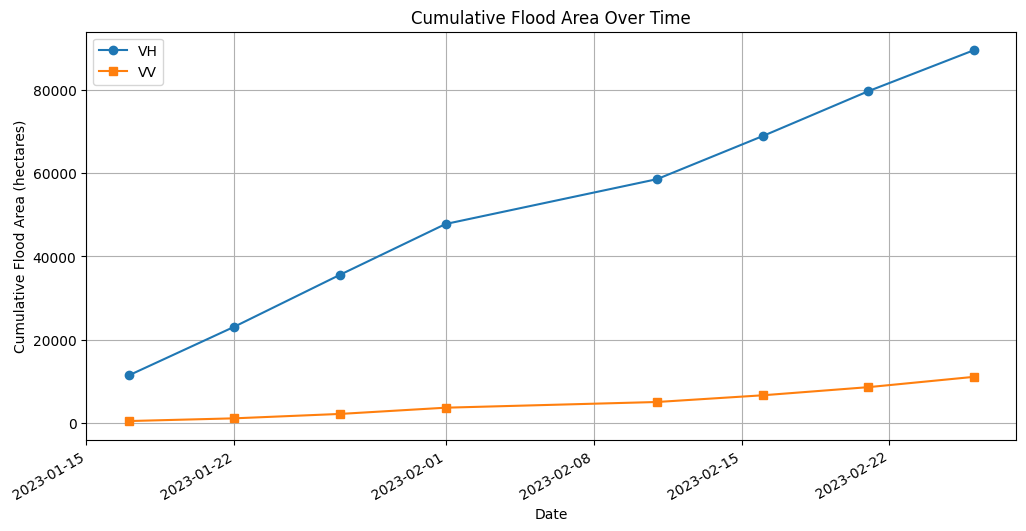

Cumulative curve plot saved to /content/drive/MyDrive/Sentinel_1_2_fusion/Sentinel_1_previous_work_flood_detection/cumulative_flood_area_plot.png
Processing complete. Export tasks started, results saved to CSV, and cumulative curve plot generated.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# ... (keep all the previous imports and functions)

def plot_cumulative_curves(df, output_path):
    """
    Plot cumulative curves for VH and VV polarizations.

    Args:
        df (pandas.DataFrame): DataFrame containing the flood area data.
        output_path (str): Path to save the plot.
    """
    # Extract dates and convert to datetime objects
    dates = [datetime.strptime(col.split('_')[0], '%Y-%m-%d') for col in df.columns if col.endswith('_VH')]
    dates = sorted(dates)

    # Calculate cumulative sums for VH and VV
    vh_cumsum = df[[col for col in df.columns if col.endswith('_VH')]].sum().cumsum().values
    vv_cumsum = df[[col for col in df.columns if col.endswith('_VV')]].sum().cumsum().values

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(dates, vh_cumsum, label='VH', marker='o')
    plt.plot(dates, vv_cumsum, label='VV', marker='s')

    plt.title('Cumulative Flood Area Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Flood Area (hectares)')
    plt.legend()
    plt.grid(True)

    # Rotate and align the tick labels so they look better
    plt.gcf().autofmt_xdate()

    # Save the plot
    plt.savefig(output_path)
    plt.show()

    print(f"Cumulative curve plot saved to {output_path}")

# ... (keep all the previous code up to the CSV export)

# Save the DataFrame to a CSV file
output_csv_path = '/content/drive/MyDrive/Sentinel_1_2_fusion/Sentinel_1_previous_work_flood_detection/final_dagana_dataframe_vh_vv.csv'
df.to_csv(output_csv_path, index=False)

# Plot cumulative curves
plot_output_path = '/content/drive/MyDrive/Sentinel_1_2_fusion/Sentinel_1_previous_work_flood_detection/cumulative_flood_area_plot.png'
plot_cumulative_curves(df, plot_output_path)

print("Processing complete. Export tasks started, results saved to CSV, and cumulative curve plot generated.")

In [ ]:
#@title using fixed thresholds
import datetime
from datetime import datetime, timedelta
import itertools
import json
from shapely.wkt import loads
import ee
import geopandas as gpd
from shapely.geometry import mapping

# Initialize Earth Engine (Make sure to authenticate first)
ee.Initialize()

def date_processing(start_date_str, end_date_str, interval_days=5, before_period_days=10):
    """
    Process date ranges for flood detection.

    Args:
        start_date_str (str): Start date in "YYYY-MM-DD" format.
        end_date_str (str): End date in "YYYY-MM-DD" format.
        interval_days (int): Interval between date ranges in days.
        before_period_days (int): Number of days for the 'before' period.

    Returns:
        tuple: before_start_date, before_end_date, list of after_date tuples.
    """
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

    before_start_date = start_date.strftime("%Y-%m-%d")
    before_end_date = (start_date + timedelta(days=before_period_days)).strftime("%Y-%m-%d")

    after_dates = []
    current_date = datetime.strptime(before_end_date, "%Y-%m-%d")
    while current_date <= end_date:
        after_end_date = (current_date + timedelta(days=interval_days)).strftime("%Y-%m-%d")
        after_dates.append((current_date.strftime("%Y-%m-%d"), after_end_date))
        current_date += timedelta(days=interval_days)

    return before_start_date, before_end_date, after_dates

def get_unique_dates(image_collection):
    """
    Get unique dates from an image collection.

    Args:
        image_collection (ee.ImageCollection): Earth Engine image collection.

    Returns:
        ee.List: List of unique date strings.
    """
    dates = image_collection.aggregate_array('system:time_start')
    unique_dates = dates.distinct().sort()
    formatted_dates = unique_dates.map(lambda date: ee.Date(date).format('YYYY-MM-dd'))
    return formatted_dates

def calculate_flood_area(start_date, end_date, geometry):
    """
    Calculate flooded area based on Sentinel-1 SAR imagery using both VH and VV polarizations.

    Args:
        start_date (str): Start date in "YYYY-MM-DD" format.
        end_date (str): End date in "YYYY-MM-DD" format.
        geometry (ee.Geometry): AOI geometry.

    Returns:
        dict: Dictionary containing dates and corresponding flood areas for both VH and VV.
        ee.ImageCollection: Collection of flood mask images for both VH and VV.
    """
    # Define the area of interest (AOI)
    aoi = geometry

    # Process date ranges
    before_start_date, before_end_date, after_dates = date_processing(start_date, end_date)

    # Load and filter Sentinel-1 ImageCollection
    s1_collection = ee.ImageCollection("COPERNICUS/S1_GRD") \
        .filterBounds(aoi) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .filter(ee.Filter.eq('resolution_meters', 10)) \
        .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
        .map(lambda image: image.clip(aoi))

    # Select both VH and VV polarizations
    before_collection = s1_collection.filterDate(before_start_date, before_end_date).select(['VH', 'VV'])
    after_collection = s1_collection.filterDate(start_date, end_date).select(['VH', 'VV'])

    # Compute the median image for the 'before' period
    before_image = before_collection.median()

    # Initialize lists to hold results
    dates_list = []
    flood_area_vh_list = []
    flood_area_vv_list = []
    flood_mask_list = []

    # Loop over each after date range
    for after_start_date, after_end_date in after_dates:
        # Filter the 'after' collection for the current date range
        after_collection_filtered = after_collection.filterDate(after_start_date, after_end_date)
        after_image = after_collection_filtered.median()

        # Check if the after_image has data
        if after_image.bandNames().size().getInfo() == 0:
            continue

        # Detect flooded areas based on fixed thresholds
        flooded_areas_vh = after_image.select('VH').lt(-20)  # Clauss et al. (2018)
        flooded_areas_vv = after_image.select('VV').lt(-19)  # Torbick et al. (2017)

        # Apply additional masks
        swater = ee.Image('JRC/GSW1_4/GlobalSurfaceWater')
        swater_mask = swater.select('transition').neq(8)

        dataset = ee.ImageCollection("ESA/WorldCover/v200").first()
        classification = dataset.select('Map').clip(aoi)
        cropland = classification.eq(40)

        # DEM = ee.Image('WWF/HydroSHEDS/03VFDEM')
        # terrain = ee.Algorithms.Terrain(DEM)
        # slope = terrain.select('slope')
        # slope_threshold = 5
        # slope_mask = slope.lt(slope_threshold)

        # Combine masks for both VH and VV
        flooded_mask_vh = flooded_areas_vh.updateMask(swater_mask).updateMask(cropland)
        flooded_mask_vv = flooded_areas_vv.updateMask(swater_mask).updateMask(cropland)
        # flooded_mask_vh = flooded_areas_vh.updateMask(swater_mask).updateMask(slope_mask).updateMask(cropland)
        # flooded_mask_vv = flooded_areas_vv.updateMask(swater_mask).updateMask(slope_mask).updateMask(cropland)

        # Remove small isolated pixels
        # connected_pixel_threshold = 8
        # connected_pixels_vh = flooded_mask_vh.connectedPixelCount(25)
        # connected_pixels_vv = flooded_mask_vv.connectedPixelCount(25)
        # flooded_mask_vh = flooded_mask_vh.updateMask(connected_pixels_vh.gte(connected_pixel_threshold))
        # flooded_mask_vv = flooded_mask_vv.updateMask(connected_pixels_vv.gte(connected_pixel_threshold))

        # Calculate the flooded area in hectares for both VH and VV
        flood_area_vh = flooded_mask_vh.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=geometry,
            scale=10,
            maxPixels=1e10
        ).get('VH')

        flood_area_vv = flooded_mask_vv.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=geometry,
            scale=10,
            maxPixels=1e10
        ).get('VV')

        flood_area_vh_ha = ee.Number(flood_area_vh).divide(10000)
        flood_area_vv_ha = ee.Number(flood_area_vv).divide(10000)

        # Get the date for labeling
        date_string = ee.Date(after_start_date).format('YYYY-MM-dd').getInfo()

        # Append results to lists
        dates_list.append(date_string)
        flood_area_vh_list.append(flood_area_vh_ha.getInfo())
        flood_area_vv_list.append(flood_area_vv_ha.getInfo())
        flood_mask_list.append(ee.Image.cat(flooded_mask_vh, flooded_mask_vv).set('date', date_string))

    # Return the results and the flood masks
    return {
        'dates': dates_list,
        'flood_area_vh': flood_area_vh_list,
        'flood_area_vv': flood_area_vv_list
    }, ee.ImageCollection(flood_mask_list)

# Asset definitions (Make sure these assets are correctly defined in your GEE account)
grid = ee.FeatureCollection("projects/ee-janet/assets/senegal/52_grid_dagana")
init_dagana = ee.FeatureCollection("projects/ee-janet/assets/senegal/updated_dagana_region")
exclusion_area = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_exclusion_region")
protected_areas = ee.FeatureCollection("WCMC/WDPA/current/polygons").filterBounds(init_dagana)
dagana = init_dagana.geometry().difference(exclusion_area.geometry()).difference(protected_areas.geometry())

# Read the grid GeoJSON file into a GeoDataFrame
grid_path = grid_path
geogrid = gpd.read_file(grid_path)
df = geogrid.copy()

# Initialize an empty list to collect all flood masks
all_flood_masks = ee.ImageCollection([])

# Iterate through the GeoDataFrame to process flood area data for each grid cell
for index, row in df.iterrows():
    print(f'Processing grid cell {index + 1}/{len(df)}')

    # Convert the geometry to Earth Engine format
    geometry_mapping = mapping(row['geometry'])
    ee_geometry = ee.Geometry(geometry_mapping)

    # Calculate flood area and get flood masks
    flood_area_values, flood_masks = calculate_flood_area(
        start_date="2024-01-03",
        end_date="2024-03-03",
        geometry=ee_geometry
    )

    # Append flood masks to the collection
    all_flood_masks = all_flood_masks.merge(flood_masks)

    # Update the DataFrame with the flood area results
    dates = flood_area_values['dates']
    flood_area_vh_list = flood_area_values['flood_area_vh']
    flood_area_vv_list = flood_area_values['flood_area_vv']
    for date, flood_area_vh, flood_area_vv in zip(dates, flood_area_vh_list, flood_area_vv_list):
        df.at[index, f'{date}_VH'] = flood_area_vh
        df.at[index, f'{date}_VV'] = flood_area_vv

# Export the flood masks as separate images for VH and VV
export_image_vh = all_flood_masks.select('VH').max().clip(dagana)
export_image_vv = all_flood_masks.select('VV').max().clip(dagana)

export_task_vh = ee.batch.Export.image.toDrive(
    image=export_image_vh,
    description='final_flooding_map_2024_vh',
    folder='EarthEngineExports',
    fileNamePrefix='final_flooding_map_2024_vh',
    region=dagana,
    scale=10,
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)
#export_task_vh.start()

export_task_vv = ee.batch.Export.image.toDrive(
    image=export_image_vv,
    description='final_flooding_map_2024_vv',
    folder='EarthEngineExports',
    fileNamePrefix='final_flooding_map_2024_vv',
    region=dagana,
    scale=10,
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)
#export_task_vv.start()

# Save the DataFrame to a CSV file
#output_csv_path = '/content/drive/MyDrive/Sentinel_1_2_fusion/Sentinel_1_previous_work_flood_detection/final_2024_dagana_dataframe_vh_vv.csv'
#df.to_csv(output_csv_path, index=False)

print("Processing complete. Export tasks started, and results saved to CSV.")

Processing grid cell 1/52
Processing grid cell 2/52
Processing grid cell 3/52
Processing grid cell 4/52
Processing grid cell 5/52
Processing grid cell 6/52
Processing grid cell 7/52
Processing grid cell 8/52
Processing grid cell 9/52
Processing grid cell 10/52
Processing grid cell 11/52
Processing grid cell 12/52
Processing grid cell 13/52
Processing grid cell 14/52
Processing grid cell 15/52
Processing grid cell 16/52
Processing grid cell 17/52
Processing grid cell 18/52
Processing grid cell 19/52
Processing grid cell 20/52
Processing grid cell 21/52
Processing grid cell 22/52
Processing grid cell 23/52
Processing grid cell 24/52
Processing grid cell 25/52
Processing grid cell 26/52
Processing grid cell 27/52
Processing grid cell 28/52
Processing grid cell 29/52
Processing grid cell 30/52
Processing grid cell 31/52
Processing grid cell 32/52
Processing grid cell 33/52
Processing grid cell 34/52
Processing grid cell 35/52
Processing grid cell 36/52
Processing grid cell 37/52
Processing

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# ... (keep all the previous imports and functions)

def plot_cumulative_curves(df, output_path):
    """
    Plot cumulative curves for VH and VV polarizations.

    Args:
        df (pandas.DataFrame): DataFrame containing the flood area data.
        output_path (str): Path to save the plot.
    """
    # Extract dates and convert to datetime objects
    dates = [datetime.strptime(col.split('_')[0], '%Y-%m-%d') for col in df.columns if col.endswith('_VH')]
    dates = sorted(dates)

    # Calculate cumulative sums for VH and VV
    vh_cumsum = df[[col for col in df.columns if col.endswith('_VH')]].sum().cumsum().values
    vv_cumsum = df[[col for col in df.columns if col.endswith('_VV')]].sum().cumsum().values

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(dates, vh_cumsum, label='VH', marker='o')
    plt.plot(dates, vv_cumsum, label='VV', marker='s')

    plt.title('Cumulative Flood Area Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Flood Area (hectares)')
    plt.legend()
    plt.grid(True)

    # Rotate and align the tick labels so they look better
    plt.gcf().autofmt_xdate()

    # Save the plot
    plt.savefig(output_path)
    plt.show()

    print(f"Cumulative curve plot saved to {output_path}")

# ... (keep all the previous code up to the CSV export)

# Save the DataFrame to a CSV file
output_csv_path = '/content/drive/MyDrive/Sentinel_1_2_fusion/Sentinel_1_previous_work_flood_detection/final_dagana_dataframe_vh_vv.csv'
df.to_csv(output_csv_path, index=False)

# Plot cumulative curves
plot_output_path = '/content/drive/MyDrive/Sentinel_1_2_fusion/Sentinel_1_previous_work_flood_detection/cumulative_flood_area_plot.png'
plot_cumulative_curves(df, plot_output_path)

print("Processing complete. Export tasks started, results saved to CSV, and cumulative curve plot generated.")

In [ ]:
#@title using fixed thresholds
import datetime
from datetime import datetime, timedelta
import itertools
import json
from shapely.wkt import loads
import ee
import geopandas as gpd
from shapely.geometry import mapping

# Initialize Earth Engine (Make sure to authenticate first)
ee.Initialize()

def date_processing(start_date_str, end_date_str, interval_days=5, before_period_days=10):
    """
    Process date ranges for flood detection.

    Args:
        start_date_str (str): Start date in "YYYY-MM-DD" format.
        end_date_str (str): End date in "YYYY-MM-DD" format.
        interval_days (int): Interval between date ranges in days.
        before_period_days (int): Number of days for the 'before' period.

    Returns:
        tuple: before_start_date, before_end_date, list of after_date tuples.
    """
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

    before_start_date = start_date.strftime("%Y-%m-%d")
    before_end_date = (start_date + timedelta(days=before_period_days)).strftime("%Y-%m-%d")

    after_dates = []
    current_date = datetime.strptime(before_end_date, "%Y-%m-%d")
    while current_date <= end_date:
        after_end_date = (current_date + timedelta(days=interval_days)).strftime("%Y-%m-%d")
        after_dates.append((current_date.strftime("%Y-%m-%d"), after_end_date))
        current_date += timedelta(days=interval_days)

    return before_start_date, before_end_date, after_dates

def get_unique_dates(image_collection):
    """
    Get unique dates from an image collection.

    Args:
        image_collection (ee.ImageCollection): Earth Engine image collection.

    Returns:
        ee.List: List of unique date strings.
    """
    dates = image_collection.aggregate_array('system:time_start')
    unique_dates = dates.distinct().sort()
    formatted_dates = unique_dates.map(lambda date: ee.Date(date).format('YYYY-MM-dd'))
    return formatted_dates

def calculate_flood_area(start_date, end_date, geometry):
    """
    Calculate flooded area based on Sentinel-1 SAR imagery using both VH and VV polarizations.

    Args:
        start_date (str): Start date in "YYYY-MM-DD" format.
        end_date (str): End date in "YYYY-MM-DD" format.
        geometry (ee.Geometry): AOI geometry.

    Returns:
        dict: Dictionary containing dates and corresponding flood areas for both VH and VV.
        ee.ImageCollection: Collection of flood mask images for both VH and VV.
    """
    # Define the area of interest (AOI)
    aoi = geometry

    # Process date ranges
    before_start_date, before_end_date, after_dates = date_processing(start_date, end_date)

    # Load and filter Sentinel-1 ImageCollection
    s1_collection = ee.ImageCollection("COPERNICUS/S1_GRD") \
        .filterBounds(aoi) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .filter(ee.Filter.eq('resolution_meters', 10)) \
        .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
        .map(lambda image: image.clip(aoi))

    # Select both VH and VV polarizations
    before_collection = s1_collection.filterDate(before_start_date, before_end_date).select(['VH', 'VV'])
    after_collection = s1_collection.filterDate(start_date, end_date).select(['VH', 'VV'])

    # Compute the median image for the 'before' period
    before_image = before_collection.median()

    # Initialize lists to hold results
    dates_list = []
    flood_area_vh_list = []
    flood_area_vv_list = []
    flood_mask_list = []

    # Loop over each after date range
    for after_start_date, after_end_date in after_dates:
        # Filter the 'after' collection for the current date range
        after_collection_filtered = after_collection.filterDate(after_start_date, after_end_date)
        after_image = after_collection_filtered.median()

        # Check if the after_image has data
        if after_image.bandNames().size().getInfo() == 0:
            continue

        # Detect flooded areas based on fixed thresholds
        flooded_areas_vh = after_image.select('VH').lt(-20)  # Clauss et al. (2018)
        flooded_areas_vv = after_image.select('VV').lt(-19)  # Torbick et al. (2017)

        # Apply additional masks
        swater = ee.Image('JRC/GSW1_4/GlobalSurfaceWater')
        swater_mask = swater.select('transition').neq(8)

        dataset = ee.ImageCollection("ESA/WorldCover/v200").first()
        classification = dataset.select('Map').clip(aoi)
        cropland = classification.eq(40)

        # DEM = ee.Image('WWF/HydroSHEDS/03VFDEM')
        # terrain = ee.Algorithms.Terrain(DEM)
        # slope = terrain.select('slope')
        # slope_threshold = 5
        # slope_mask = slope.lt(slope_threshold)

        # Combine masks for both VH and VV
        flooded_mask_vh = flooded_areas_vh.updateMask(swater_mask).updateMask(cropland)
        flooded_mask_vv = flooded_areas_vv.updateMask(swater_mask).updateMask(cropland)
        # flooded_mask_vh = flooded_areas_vh.updateMask(swater_mask).updateMask(slope_mask).updateMask(cropland)
        # flooded_mask_vv = flooded_areas_vv.updateMask(swater_mask).updateMask(slope_mask).updateMask(cropland)

        # Remove small isolated pixels
        # connected_pixel_threshold = 8
        # connected_pixels_vh = flooded_mask_vh.connectedPixelCount(25)
        # connected_pixels_vv = flooded_mask_vv.connectedPixelCount(25)
        # flooded_mask_vh = flooded_mask_vh.updateMask(connected_pixels_vh.gte(connected_pixel_threshold))
        # flooded_mask_vv = flooded_mask_vv.updateMask(connected_pixels_vv.gte(connected_pixel_threshold))

        # Calculate the flooded area in hectares for both VH and VV
        flood_area_vh = flooded_mask_vh.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=geometry,
            scale=10,
            maxPixels=1e10
        ).get('VH')

        flood_area_vv = flooded_mask_vv.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=geometry,
            scale=10,
            maxPixels=1e10
        ).get('VV')

        flood_area_vh_ha = ee.Number(flood_area_vh).divide(10000)
        flood_area_vv_ha = ee.Number(flood_area_vv).divide(10000)

        # Get the date for labeling
        date_string = ee.Date(after_start_date).format('YYYY-MM-dd').getInfo()

        # Append results to lists
        dates_list.append(date_string)
        flood_area_vh_list.append(flood_area_vh_ha.getInfo())
        flood_area_vv_list.append(flood_area_vv_ha.getInfo())
        flood_mask_list.append(ee.Image.cat(flooded_mask_vh, flooded_mask_vv).set('date', date_string))

    # Return the results and the flood masks
    return {
        'dates': dates_list,
        'flood_area_vh': flood_area_vh_list,
        'flood_area_vv': flood_area_vv_list
    }, ee.ImageCollection(flood_mask_list)

# Asset definitions (Make sure these assets are correctly defined in your GEE account)
grid = ee.FeatureCollection("projects/ee-janet/assets/senegal/52_grid_dagana")
init_dagana = ee.FeatureCollection("projects/ee-janet/assets/senegal/updated_dagana_region")
exclusion_area = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_exclusion_region")
protected_areas = ee.FeatureCollection("WCMC/WDPA/current/polygons").filterBounds(init_dagana)
dagana = init_dagana.geometry().difference(exclusion_area.geometry()).difference(protected_areas.geometry())

# Read the grid GeoJSON file into a GeoDataFrame
grid_path = 'grid52_dagana.geojson'
geogrid = gpd.read_file(grid_path)
df = geogrid.copy()

# Initialize an empty list to collect all flood masks
all_flood_masks = ee.ImageCollection([])

# Iterate through the GeoDataFrame to process flood area data for each grid cell
for index, row in df.iterrows():
    print(f'Processing grid cell {index + 1}/{len(df)}')

    # Convert the geometry to Earth Engine format
    geometry_mapping = mapping(row['geometry'])
    ee_geometry = ee.Geometry(geometry_mapping)

    # Calculate flood area and get flood masks
    flood_area_values, flood_masks = calculate_flood_area(
        start_date="2022-01-03",
        end_date="2022-07-31",
        geometry=ee_geometry
    )

    # Append flood masks to the collection
    all_flood_masks = all_flood_masks.merge(flood_masks)

    # Update the DataFrame with the flood area results
    dates = flood_area_values['dates']
    flood_area_vh_list = flood_area_values['flood_area_vh']
    flood_area_vv_list = flood_area_values['flood_area_vv']
    for date, flood_area_vh, flood_area_vv in zip(dates, flood_area_vh_list, flood_area_vv_list):
        df.at[index, f'{date}_VH'] = flood_area_vh
        df.at[index, f'{date}_VV'] = flood_area_vv

# Export the flood masks as separate images for VH and VV
export_image_vh = all_flood_masks.select('VH').max().clip(dagana)
export_image_vv = all_flood_masks.select('VV').max().clip(dagana)

export_task_vh = ee.batch.Export.image.toDrive(
    image=export_image_vh,
    description='final_flooding_map_2022_vh',
    folder='EarthEngineExports',
    fileNamePrefix='final_flooding_map_2022_vh',
    region=dagana,
    scale=10,
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)
export_task_vh.start()

export_task_vv = ee.batch.Export.image.toDrive(
    image=export_image_vv,
    description='final_flooding_map_2022_vv',
    folder='EarthEngineExports',
    fileNamePrefix='final_flooding_map_2022_vv',
    region=dagana,
    scale=10,
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)
export_task_vv.start()

# Save the DataFrame to a CSV file
output_csv_path = '/content/drive/MyDrive/Sentinel_1_2_fusion/Sentinel_1_previous_work_flood_detection/final_2022_dagana_dataframe_vh_vv.csv'
df.to_csv(output_csv_path, index=False)

print("Processing complete. Export tasks started, and results saved to CSV.")

Processing grid cell 1/52
Processing grid cell 2/52
Processing grid cell 3/52
Processing grid cell 4/52
Processing grid cell 5/52
Processing grid cell 6/52
Processing grid cell 7/52
Processing grid cell 8/52
Processing grid cell 9/52
Processing grid cell 10/52
Processing grid cell 11/52
Processing grid cell 12/52
Processing grid cell 13/52
Processing grid cell 14/52
Processing grid cell 15/52
Processing grid cell 16/52
Processing grid cell 17/52
Processing grid cell 18/52
Processing grid cell 19/52
Processing grid cell 20/52
Processing grid cell 21/52
Processing grid cell 22/52
Processing grid cell 23/52
Processing grid cell 24/52
Processing grid cell 25/52
Processing grid cell 26/52
Processing grid cell 27/52
Processing grid cell 28/52
Processing grid cell 29/52
Processing grid cell 30/52
Processing grid cell 31/52
Processing grid cell 32/52
Processing grid cell 33/52
Processing grid cell 34/52
Processing grid cell 35/52
Processing grid cell 36/52
Processing grid cell 37/52
Processing

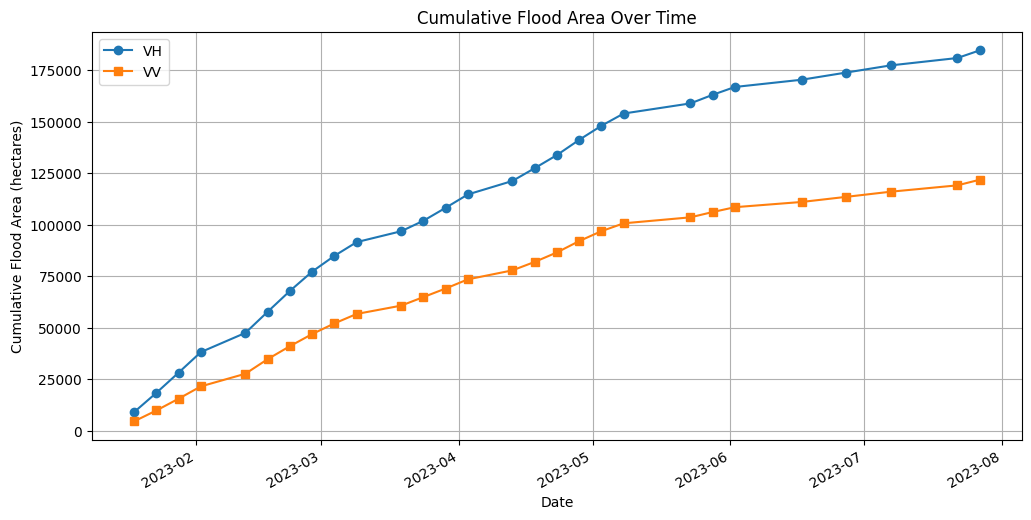

Cumulative curve plot saved to /content/drive/MyDrive/Sentinel_1_2_fusion/Sentinel_1_previous_work_flood_detection/cumulative_flood_area_plot.png
Processing complete. Export tasks started, results saved to CSV, and cumulative curve plot generated.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# ... (keep all the previous imports and functions)

def plot_cumulative_curves(df, output_path):
    """
    Plot cumulative curves for VH and VV polarizations.

    Args:
        df (pandas.DataFrame): DataFrame containing the flood area data.
        output_path (str): Path to save the plot.
    """
    # Extract dates and convert to datetime objects
    dates = [datetime.strptime(col.split('_')[0], '%Y-%m-%d') for col in df.columns if col.endswith('_VH')]
    dates = sorted(dates)

    # Calculate cumulative sums for VH and VV
    vh_cumsum = df[[col for col in df.columns if col.endswith('_VH')]].sum().cumsum().values
    vv_cumsum = df[[col for col in df.columns if col.endswith('_VV')]].sum().cumsum().values

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(dates, vh_cumsum, label='VH', marker='o')
    plt.plot(dates, vv_cumsum, label='VV', marker='s')

    plt.title('Cumulative Flood Area Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Flood Area (hectares)')
    plt.legend()
    plt.grid(True)

    # Rotate and align the tick labels so they look better
    plt.gcf().autofmt_xdate()

    # Save the plot
    plt.savefig(output_path)
    plt.show()

    print(f"Cumulative curve plot saved to {output_path}")

# ... (keep all the previous code up to the CSV export)

# Save the DataFrame to a CSV file
output_csv_path = '/content/drive/MyDrive/Sentinel_1_2_fusion/Sentinel_1_previous_work_flood_detection/final_dagana_dataframe_vh_vv.csv'
df.to_csv(output_csv_path, index=False)

# Plot cumulative curves
plot_output_path = '/content/drive/MyDrive/Sentinel_1_2_fusion/Sentinel_1_previous_work_flood_detection/cumulative_flood_area_plot.png'
plot_cumulative_curves(df, plot_output_path)

print("Processing complete. Export tasks started, results saved to CSV, and cumulative curve plot generated.")

In [ ]:
df

In [ ]:
  dates = [datetime.strptime(col.split('_')[0], '%Y-%m-%d') for col in df.columns if col.endswith('_VH')]
  dates

[datetime.datetime(2023, 1, 18, 0, 0),
 datetime.datetime(2023, 1, 28, 0, 0),
 datetime.datetime(2023, 2, 12, 0, 0),
 datetime.datetime(2023, 2, 22, 0, 0),
 datetime.datetime(2023, 3, 4, 0, 0),
 datetime.datetime(2023, 3, 19, 0, 0),
 datetime.datetime(2023, 3, 29, 0, 0),
 datetime.datetime(2023, 4, 13, 0, 0),
 datetime.datetime(2023, 4, 23, 0, 0),
 datetime.datetime(2023, 5, 3, 0, 0),
 datetime.datetime(2023, 1, 23, 0, 0),
 datetime.datetime(2023, 2, 2, 0, 0),
 datetime.datetime(2023, 2, 17, 0, 0),
 datetime.datetime(2023, 2, 27, 0, 0),
 datetime.datetime(2023, 3, 9, 0, 0),
 datetime.datetime(2023, 3, 24, 0, 0),
 datetime.datetime(2023, 4, 3, 0, 0),
 datetime.datetime(2023, 4, 18, 0, 0),
 datetime.datetime(2023, 4, 28, 0, 0),
 datetime.datetime(2023, 5, 8, 0, 0),
 datetime.datetime(2023, 5, 23, 0, 0)]

In [ ]:
vv_cumsum = df[[col for col in df.columns if col.endswith('_VV')]].sum().cumsum().values
vh_cumsum = df[[col for col in df.columns if col.endswith('_VH')]].sum().cumsum().values

In [ ]:
vh_cumsum

array([ 11430.84640442,  23113.65494393,  35567.80225988,  47753.68270794,
        58842.31133228,  71371.32540199,  83724.80902165,  95607.63940339,
       105704.62758704, 114412.66731834, 125165.75154154, 135491.47629599,
       146259.55627709, 156101.75621505, 165966.63715294, 177426.58128168,
       188508.54777536, 198960.58112426, 208395.69629493, 216800.53093777,
       224720.43452634])

In [ ]:
vv_cumsum

array([  504.71922827,  1156.52411002,  2211.40741675,  3706.7401878 ,
        5549.62121472,  7258.14893801,  9426.43399373, 10693.28273645,
       11282.1479034 , 11806.16248715, 13173.35830464, 14779.97683038,
       16732.31998147, 19204.89790883, 21752.64569003, 24704.39650927,
       26933.28121262, 28419.31152839, 29397.39680425, 30216.0606956 ,
       30993.80543277])

In [ ]:
#@title Steven copy
import datetime
from datetime import datetime, timedelta
import itertools
import json
from shapely.wkt import loads
import ee
import geopandas as gpd
from shapely.geometry import mapping

# Initialize Earth Engine (Make sure to authenticate first)
ee.Initialize()

def date_processing(start_date_str, end_date_str, interval_days=5, before_period_days=10):
    """
    Process date ranges for flood detection.

    Args:
        start_date_str (str): Start date in "YYYY-MM-DD" format.
        end_date_str (str): End date in "YYYY-MM-DD" format.
        interval_days (int): Interval between date ranges in days.
        before_period_days (int): Number of days for the 'before' period.

    Returns:
        tuple: before_start_date, before_end_date, list of after_date tuples.
    """
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

    before_start_date = start_date.strftime("%Y-%m-%d")
    before_end_date = (start_date + timedelta(days=before_period_days)).strftime("%Y-%m-%d")

    after_dates = []
    current_date = datetime.strptime(before_end_date, "%Y-%m-%d")
    while current_date <= end_date:
        after_end_date = (current_date + timedelta(days=interval_days)).strftime("%Y-%m-%d")
        after_dates.append((current_date.strftime("%Y-%m-%d"), after_end_date))
        current_date += timedelta(days=interval_days)

    return before_start_date, before_end_date, after_dates

def get_unique_dates(image_collection):
    """
    Get unique dates from an image collection.

    Args:
        image_collection (ee.ImageCollection): Earth Engine image collection.

    Returns:
        ee.List: List of unique date strings.
    """
    dates = image_collection.aggregate_array('system:time_start')
    unique_dates = dates.distinct().sort()
    formatted_dates = unique_dates.map(lambda date: ee.Date(date).format('YYYY-MM-dd'))
    return formatted_dates

def add_ratio_band(image):
    """
    Add a ratio band (VV/VH) to an image.

    Args:
        image (ee.Image): Input image.

    Returns:
        ee.Image: Image with added ratio band.
    """
    vv_band = image.select('VV')
    vh_band = image.select('VH')
    ratio_band = vv_band.divide(vh_band).rename('VV_div_VH')
    return image.addBands(ratio_band)

def calculate_flood_area(start_date, end_date, geometry, polarization='VV', difference_threshold=-3):
    """
    Calculate flooded area based on Sentinel-1 SAR imagery.

    Args:
        start_date (str): Start date in "YYYY-MM-DD" format.
        end_date (str): End date in "YYYY-MM-DD" format.
        geometry (ee.Geometry): AOI geometry.
        polarization (str): Polarization mode ('VV', 'VH', or 'VV/VH').
        difference_threshold (float): Difference threshold for flood detection.

    Returns:
        dict: Dictionary containing dates and corresponding flood areas.
        ee.ImageCollection: Collection of flood mask images.
    """
    # Define the area of interest (AOI)
    aoi = geometry

    # Process date ranges
    before_start_date, before_end_date, after_dates = date_processing(start_date, end_date)

    # Load and filter Sentinel-1 ImageCollection
    s1_collection = ee.ImageCollection("COPERNICUS/S1_GRD") \
        .filterBounds(aoi) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .filter(ee.Filter.eq('resolution_meters', 10)) \
        .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
        .map(lambda image: image.clip(aoi))

    # Select the appropriate polarization
    if polarization in ['VV', 'VH']:
        before_collection = s1_collection.filterDate(before_start_date, before_end_date).select(polarization)
        after_collection = s1_collection.filterDate(start_date, end_date).select(polarization)
    elif polarization == 'VV/VH':
        before_collection = s1_collection.filterDate(before_start_date, before_end_date).map(add_ratio_band).select('VV_div_VH')
        after_collection = s1_collection.filterDate(start_date, end_date).map(add_ratio_band).select('VV_div_VH')
    else:
        raise ValueError("Invalid polarization option. Choose 'VV', 'VH', or 'VV/VH'.")

    # Compute the median image for the 'before' period
    before_image = before_collection.median()

    # Initialize lists to hold results
    dates_list = []
    flood_area_list = []
    flood_mask_list = []

    # Loop over each after date range
    for after_start_date, after_end_date in after_dates:
        # Filter the 'after' collection for the current date range
        after_collection_filtered = after_collection.filterDate(after_start_date, after_end_date)
        after_image = after_collection_filtered.median()

        # Check if the after_image has data
        if after_image.bandNames().size().getInfo() == 0:
            continue

        # Compute the difference between 'after' and 'before' images
        diff_image = after_image.subtract(before_image)

        # Detect flooded areas based on the difference threshold
        flooded_areas = diff_image.lt(difference_threshold)

        # Apply additional masks
        # Load auxiliary datasets for masking
        swater = ee.Image('JRC/GSW1_4/GlobalSurfaceWater')
        swater_mask = swater.select('transition').neq(8)

        dataset = ee.ImageCollection("ESA/WorldCover/v200").first()
        classification = dataset.select('Map').clip(aoi)
        cropland = classification.eq(40)

        DEM = ee.Image('WWF/HydroSHEDS/03VFDEM')
        terrain = ee.Algorithms.Terrain(DEM)
        slope = terrain.select('slope')
        slope_threshold = 5
        slope_mask = slope.lt(slope_threshold)

        # Combine masks
        flooded_mask = flooded_areas \
            .updateMask(swater_mask) \
            .updateMask(slope_mask) \
            .updateMask(cropland)

        # Remove small isolated pixels
        connected_pixel_threshold = 8
        connected_pixels = flooded_mask.connectedPixelCount(25)
        flooded_mask = flooded_mask.updateMask(connected_pixels.gte(connected_pixel_threshold))

        # Calculate the flooded area in hectares
        flood_area = flooded_mask.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=geometry,
            scale=10,
            maxPixels=1e10
        ).get(polarization)

        flood_area_ha = ee.Number(flood_area).divide(10000)

        # Get the date for labeling
        date_string = ee.Date(after_start_date).format('YYYY-MM-dd').getInfo()

        # Append results to lists
        dates_list.append(date_string)
        flood_area_list.append(flood_area_ha.getInfo())
        flood_mask_list.append(flooded_mask.set('date', date_string))

    # Return the results and the flood masks
    return {'dates': dates_list, 'flood_area': flood_area_list}, ee.ImageCollection(flood_mask_list)

# Asset definitions (Make sure these assets are correctly defined in your GEE account)
grid = ee.FeatureCollection("projects/ee-janet/assets/senegal/52_grid_dagana")
init_dagana = ee.FeatureCollection("projects/ee-janet/assets/senegal/updated_dagana_region")
exclusion_area = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_exclusion_region")
protected_areas = ee.FeatureCollection("WCMC/WDPA/current/polygons").filterBounds(init_dagana)
dagana = init_dagana.geometry().difference(exclusion_area.geometry()).difference(protected_areas.geometry())

# Read the grid GeoJSON file into a GeoDataFrame
grid_path = 'grid52_dagana.geojson'
geogrid = gpd.read_file(grid_path)
df = geogrid.copy()

# Initialize an empty list to collect all flood masks
all_flood_masks = ee.ImageCollection([])

# Iterate through the GeoDataFrame to process flood area data for each grid cell
for index, row in df.iterrows():
    print(f'Processing grid cell {index + 1}/{len(df)}')

    # Convert the geometry to Earth Engine format
    geometry_mapping = mapping(row['geometry'])
    ee_geometry = ee.Geometry(geometry_mapping)

    # Calculate flood area and get flood masks
    flood_area_values, flood_masks = calculate_flood_area(
        start_date="2023-01-03",
        end_date="2023-05-30",
        geometry=ee_geometry,
        polarization='VH',
        difference_threshold=-3  # Adjust threshold as needed
    )

    # Append flood masks to the collection
    all_flood_masks = all_flood_masks.merge(flood_masks)

    # Update the DataFrame with the flood area results
    dates = flood_area_values['dates']
    flood_area_list = flood_area_values['flood_area']
    for date, flood_area in zip(dates, flood_area_list):
        df.at[index, date] = flood_area

# Export the flood masks as an image
export_image = all_flood_masks.max().clip(dagana)
export_task = ee.batch.Export.image.toDrive(
    image=export_image,
    description='new_final_dagana_map_vh',
    folder='EarthEngineExports',
    fileNamePrefix='new_final_dagana_map_vh',
    region=dagana,
    scale=10,
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)
export_task.start()

# Save the DataFrame to a CSV file
output_csv_path = '/content/drive/MyDrive/Sentinel_1_2_fusion/Sentinel_1_previous_work_flood_detection/new_final_dagana_dataframe_vh.csv'
df.to_csv(output_csv_path, index=False)

print("Processing complete. Export task started, and results saved to CSV.")

geometry_mapping = mapping(row['geometry'])
ee_geometry = ee.Geometry(geometry_mapping)

Processing grid cell 1/52
Processing grid cell 2/52
Processing grid cell 3/52
Processing grid cell 4/52
Processing grid cell 5/52
Processing grid cell 6/52
Processing grid cell 7/52
Processing grid cell 8/52
Processing grid cell 9/52
Processing grid cell 10/52
Processing grid cell 11/52
Processing grid cell 12/52
Processing grid cell 13/52
Processing grid cell 14/52
Processing grid cell 15/52
Processing grid cell 16/52
Processing grid cell 17/52
Processing grid cell 18/52
Processing grid cell 19/52
Processing grid cell 20/52
Processing grid cell 21/52
Processing grid cell 22/52
Processing grid cell 23/52
Processing grid cell 24/52
Processing grid cell 25/52
Processing grid cell 26/52
Processing grid cell 27/52
Processing grid cell 28/52
Processing grid cell 29/52
Processing grid cell 30/52
Processing grid cell 31/52
Processing grid cell 32/52
Processing grid cell 33/52
Processing grid cell 34/52
Processing grid cell 35/52
Processing grid cell 36/52
Processing grid cell 37/52
Processing

In [ ]:
import datetime
from datetime import datetime, timedelta
import itertools
import json
from shapely.wkt import loads
import ee
import geopandas as gpd
import pandas as pd
# Initialize Earth Engine (Make sure to authenticate first)
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()


# Function to fill NA values with previous column's value
def fill_na_with_previous(row):
    previous_value = row[sorted_date_columns[0]]
    for col in sorted_date_columns[1:]:
        if pd.isna(row[col]):
            row[col] = previous_value
        else:
            previous_value = row[col]
    return row

def date_processing(start_date_str, end_date_str, interval_days=5, before_period_days=10):
    """
    Process date ranges for flood detection.

    Args:
        start_date_str (str): Start date in "YYYY-MM-DD" format.
        end_date_str (str): End date in "YYYY-MM-DD" format.
        interval_days (int): Interval between date ranges in days.
        before_period_days (int): Number of days for the 'before' period.

    Returns:
        tuple: before_start_date, before_end_date, list of after_date tuples.
    """
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

    before_start_date = start_date.strftime("%Y-%m-%d")
    before_end_date = (start_date + timedelta(days=before_period_days)).strftime("%Y-%m-%d")

    after_dates = []
    current_date = datetime.strptime(before_end_date, "%Y-%m-%d")
    while current_date <= end_date:
        after_end_date = (current_date + timedelta(days=interval_days)).strftime("%Y-%m-%d")
        after_dates.append((current_date.strftime("%Y-%m-%d"), after_end_date))
        current_date += timedelta(days=interval_days)

    return before_start_date, before_end_date, after_dates

def add_ratio_band(image):
    """
    Add a ratio band (VV/VH) to an image.

    Args:
        image (ee.Image): Input image.

    Returns:
        ee.Image: Image with added ratio band.
    """
    vv_band = image.select('VV')
    vh_band = image.select('VH')
    ratio_band = vv_band.divide(vh_band).rename('VV_div_VH')
    return image.addBands(ratio_band)

def calculate_flood_area_cumulative(start_date, end_date, geometry, polarization='VV', difference_threshold=-3):
    """
    Calculate cumulative flooded area based on Sentinel-1 SAR imagery.

    Args:
        start_date (str): Start date in "YYYY-MM-DD" format.
        end_date (str): End date in "YYYY-MM-DD" format.
        geometry (ee.Geometry): AOI geometry.
        polarization (str): Polarization mode ('VV', 'VH', or 'VV/VH').
        difference_threshold (float): Difference threshold for flood detection.

    Returns:
        dict: Dictionary containing dates and corresponding cumulative flood areas.
        ee.ImageCollection: Collection of cumulative flood mask images.
    """
    # Define the area of interest (AOI)
    aoi = geometry

    # Process date ranges
    before_start_date, before_end_date, after_dates = date_processing(start_date, end_date)

    # Load and filter Sentinel-1 ImageCollection
    s1_collection = ee.ImageCollection("COPERNICUS/S1_GRD") \
        .filterBounds(aoi) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .filter(ee.Filter.eq('resolution_meters', 10)) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
        .map(lambda image: image.clip(aoi))

    # Select the appropriate polarization
    if polarization in ['VV', 'VH']:
        before_collection = s1_collection.filterDate(before_start_date, before_end_date).select(polarization)
        after_collection = s1_collection.filterDate(start_date, end_date).select(polarization)
    elif polarization == 'VV/VH':
        before_collection = s1_collection.filterDate(before_start_date, before_end_date).map(add_ratio_band).select('VV_div_VH')
        after_collection = s1_collection.filterDate(start_date, end_date).map(add_ratio_band).select('VV_div_VH')
    else:
        raise ValueError("Invalid polarization option. Choose 'VV', 'VH', or 'VV/VH'.")

    # Compute the median image for the 'before' period
    before_image = before_collection.median()

    # Initialize cumulative flood mask with zeros and a consistent band name
    cumulative_flood_mask = ee.Image(0).rename('flooded').clip(aoi)

    # Initialize lists to hold results
    dates_list = []
    flood_area_list = []
    flood_mask_list = []

    # Loop over each after date range
    for after_start_date, after_end_date in after_dates:
        # Filter the 'after' collection for the current date range
        after_collection_filtered = after_collection.filterDate(after_start_date, after_end_date)
        after_image = after_collection_filtered.median()

        # Check if the after_image has data
        if after_image.bandNames().size().getInfo() == 0:
            continue

        # Compute the difference between 'after' and 'before' images
        diff_image = after_image.subtract(before_image)

        # Detect flooded areas based on the difference threshold
        flooded_areas = diff_image.lt(difference_threshold).rename('flooded')

        # Apply additional masks
        # Load auxiliary datasets for masking
        swater = ee.Image('JRC/GSW1_4/GlobalSurfaceWater')
        swater_mask = swater.select('transition').neq(8)

        dataset = ee.ImageCollection("ESA/WorldCover/v200").first()
        classification = dataset.select('Map').clip(aoi)
        #cropland = classification.eq(40)

        DEM = ee.Image('WWF/HydroSHEDS/03VFDEM')
        terrain = ee.Algorithms.Terrain(DEM)
        slope = terrain.select('slope')
        slope_threshold = 5
        slope_mask = slope.lt(slope_threshold)

        # Combine masks
        flooded_mask = flooded_areas \
            .updateMask(swater_mask) \
            .updateMask(slope_mask) \
            .rename('flooded')  # Ensure band name is 'flooded'

        # Remove small isolated pixels
        connected_pixel_threshold = 8
        connected_pixels = flooded_mask.connectedPixelCount(25)
        flooded_mask = flooded_mask.updateMask(connected_pixels.gte(connected_pixel_threshold))

        # Unmask images to ensure proper logical OR operation
        cumulative_flood_mask_unmasked = cumulative_flood_mask.unmask(0)
        flooded_mask_unmasked = flooded_mask.unmask(0)

        # Update cumulative flood mask using logical OR
        cumulative_flood_mask = cumulative_flood_mask_unmasked.Or(flooded_mask_unmasked).rename('flooded').clip(aoi)

        # Calculate the cumulative flooded area in hectares
        flood_area = cumulative_flood_mask.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=geometry,
            scale=10,
            maxPixels=1e10
        ).get('flooded')

        # Handle cases where flood_area might be None
        flood_area_ha = ee.Number(flood_area).divide(10000) if flood_area else ee.Number(0)

        # Get the date for labeling
        date_string = ee.Date(after_start_date).format('YYYY-MM-dd').getInfo()

        # Append results to lists
        dates_list.append(date_string)
        flood_area_list.append(flood_area_ha.getInfo())
        flood_mask_list.append(cumulative_flood_mask.set('date', date_string))

    # Sort dates and corresponding flood areas in ascending order
    combined = sorted(zip(dates_list, flood_area_list, flood_mask_list), key=lambda x: x[0])
    dates_list, flood_area_list, flood_mask_list = zip(*combined)
    #print('dates_list', dates_list)
    #print('flood_area_list', flood_area_list)

    # Replace zeros in flood_area_list with the preceding non-zero value
    flood_area_list = list(flood_area_list)
    for i in range(1, len(flood_area_list)):
        if flood_area_list[i] == 0:
            flood_area_list[i] = flood_area_list[i - 1]

    # Return the results and the cumulative flood masks
    return {'dates': dates_list, 'flood_area': flood_area_list}, ee.ImageCollection(flood_mask_list)

# Asset definitions (Make sure these assets are correctly defined in your GEE account)
grid = ee.FeatureCollection("projects/ee-janet/assets/senegal/52_grid_dagana")
init_dagana = ee.FeatureCollection("projects/ee-janet/assets/senegal/updated_dagana_region")
exclusion_area = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_exclusion_region")
protected_areas = ee.FeatureCollection("WCMC/WDPA/current/polygons").filterBounds(init_dagana)
dagana = init_dagana.geometry().difference(exclusion_area.geometry()).difference(protected_areas.geometry())

# Read the grid GeoJSON file into a GeoDataFrame
grid_path = 'grid52_dagana.geojson'
geogrid = gpd.read_file(grid_path)

# Ensure the geometries are in WGS84 (EPSG:4326)
geogrid = geogrid.to_crs(epsg=4326)
df = geogrid.copy()

# Initialize an empty ImageCollection to collect all cumulative flood masks
all_flood_masks = ee.ImageCollection([])

# Iterate through the GeoDataFrame to process flood area data for each grid cell
for index, row in df.iterrows():
    print(f'Processing grid cell {index + 1}/{len(df)}')


    # Convert the geometry to Earth Engine format
    geometry_geojson = row['geometry'].__geo_interface__
    ee_geometry = ee.Geometry(geometry_geojson)

    # Calculate cumulative flood area and get cumulative flood masks
    flood_area_values, flood_masks = calculate_flood_area_cumulative(
        start_date="2023-01-03",
        end_date="2023-05-30",
        geometry=ee_geometry,
        polarization='VH',
        difference_threshold=-3  # Adjust threshold as needed
    )

    # Append cumulative flood masks to the collection
    all_flood_masks = all_flood_masks.merge(flood_masks)

    # Update the DataFrame with the cumulative flood area results
    dates = flood_area_values['dates']
    flood_area_list = flood_area_values['flood_area']

    # Convert dates and flood_area_list to lists if they are not already
    dates = list(dates)
    flood_area_list = list(flood_area_list)

    for date, flood_area in zip(dates, flood_area_list):
        df.at[index, date] = flood_area

#df['flooding_date'] = df[columns_date].idxmax(axis=1)
# Export the cumulative flood masks as an image
export_image = all_flood_masks.max().clip(dagana)
export_task = ee.batch.Export.image.toDrive(
    image=export_image,
    description='new_final_dagana_cumulative_map_vh',
    folder='EarthEngineExports',
    fileNamePrefix='new_final_dagana_cumulative_map_vh',
    region=dagana,
    scale=10,
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)
export_task.start()

# Save the DataFrame to a CSV file
output_csv_path = '/content/drive/MyDrive/Sentinel_1_2_fusion/Sentinel_1_previous_work_flood_detection/new_final_dagana_dataframe_vh.csv'
date_columns = df.filter(regex=r'\d{4}-\d{2}-\d{2}').columns
date_columns_datetime = pd.to_datetime(date_columns, format='%Y-%m-%d')
sorted_date_columns_datetime = sorted(date_columns_datetime)
sorted_date_columns = [dt.strftime('%Y-%m-%d') for dt in sorted_date_columns_datetime]
df = df[['ID', 'Latitude', 'Longitude', 'nasapid', 'LatNP', 'LonNP', 'geometry'] + sorted_date_columns]
df[sorted_date_columns] = df.apply(fill_na_with_previous, axis=1)[sorted_date_columns]
df.to_csv(output_csv_path, index=False)

print("Processing complete. Export task started, and results saved to CSV.")


In [ ]:

import geemap



# Define the center coordinates of your AOI
center_lat = 16.0  # Replace with your AOI's latitude
center_lon = -15.0  # Replace with your AOI's longitude

# Create a Map instance
Map = geemap.Map(center=[center_lat, center_lon], zoom=8)

# Define visualization parameters
viz_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'blue']
}

# Add the cumulative flood mask image to the map
Map.addLayer(export_image, viz_params, 'Cumulative Flood Mask')

# Add a layer control panel
Map.addLayerControl()

# Display the map
Map


NameError: name 'export_image' is not defined

In [ ]:
date_columns = df.filter(regex=r'\d{4}-\d{2}-\d{2}').columns
date_columns_datetime = pd.to_datetime(date_columns, format='%Y-%m-%d')
sorted_date_columns_datetime = sorted(date_columns_datetime)
sorted_date_columns = [dt.strftime('%Y-%m-%d') for dt in sorted_date_columns_datetime]
df = df[['ID', 'Latitude', 'Longitude', 'nasapid', 'LatNP', 'LonNP', 'geometry'] + sorted_date_columns]
df[sorted_date_columns] = df.apply(fill_na_with_previous, axis=1)[sorted_date_columns]
df.to_csv(output_csv_path, index=False)

In [ ]:
#@title Editing this copy
import datetime
from datetime import datetime, timedelta
import itertools
import json
from shapely.wkt import loads
import ee
import geopandas as gpd
import pandas as pd
# Initialize Earth Engine (Make sure to authenticate first)
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()


# Function to fill NA values with previous column's value
def fill_na_with_previous(row):
    previous_value = row[sorted_date_columns[0]]
    for col in sorted_date_columns[1:]:
        if pd.isna(row[col]):
            row[col] = previous_value
        else:
            previous_value = row[col]
    return row

def date_processing(start_date_str, end_date_str, interval_days=5, before_period_days=10):
    """
    Process date ranges for flood detection.

    Args:
        start_date_str (str): Start date in "YYYY-MM-DD" format.
        end_date_str (str): End date in "YYYY-MM-DD" format.
        interval_days (int): Interval between date ranges in days.
        before_period_days (int): Number of days for the 'before' period.

    Returns:
        tuple: before_start_date, before_end_date, list of after_date tuples.
    """
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

    before_start_date = start_date.strftime("%Y-%m-%d")
    before_end_date = (start_date + timedelta(days=before_period_days)).strftime("%Y-%m-%d")

    after_dates = []
    current_date = datetime.strptime(before_end_date, "%Y-%m-%d")
    while current_date <= end_date:
        after_end_date = (current_date + timedelta(days=interval_days)).strftime("%Y-%m-%d")
        after_dates.append((current_date.strftime("%Y-%m-%d"), after_end_date))
        current_date += timedelta(days=interval_days)

    return before_start_date, before_end_date, after_dates

def add_ratio_band(image):
    """
    Add a ratio band (VV/VH) to an image.

    Args:
        image (ee.Image): Input image.

    Returns:
        ee.Image: Image with added ratio band.
    """
    vv_band = image.select('VV')
    vh_band = image.select('VH')
    ratio_band = vv_band.divide(vh_band).rename('VV_div_VH')
    return image.addBands(ratio_band)

def calculate_flood_area_cumulative(start_date, end_date, geometry, polarization='VV', difference_threshold=1.3):
    """
    Calculate cumulative flooded area based on Sentinel-1 SAR imagery.

    Args:
        start_date (str): Start date in "YYYY-MM-DD" format.
        end_date (str): End date in "YYYY-MM-DD" format.
        geometry (ee.Geometry): AOI geometry.
        polarization (str): Polarization mode ('VV', 'VH', or 'VV/VH').
        difference_threshold (float): Difference threshold for flood detection.

    Returns:
        dict: Dictionary containing dates and corresponding cumulative flood areas.
        ee.ImageCollection: Collection of cumulative flood mask images.
    """
    # Define the area of interest (AOI)
    aoi = geometry

    # Process date ranges
    before_start_date, before_end_date, after_dates = date_processing(start_date, end_date)

    # Load and filter Sentinel-1 ImageCollection
    s1_collection = ee.ImageCollection("COPERNICUS/S1_GRD") \
        .filterBounds(aoi) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .filter(ee.Filter.eq('resolution_meters', 10)) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
        .map(lambda image: image.clip(aoi))

    # Select the appropriate polarization
    if polarization in ['VV', 'VH']:
        before_collection = s1_collection.filterDate(before_start_date, before_end_date).select(polarization)
        after_collection = s1_collection.filterDate(start_date, end_date).select(polarization)
    elif polarization == 'VV/VH':
        before_collection = s1_collection.filterDate(before_start_date, before_end_date).map(add_ratio_band).select('VV_div_VH')
        after_collection = s1_collection.filterDate(start_date, end_date).map(add_ratio_band).select('VV_div_VH')
    else:
        raise ValueError("Invalid polarization option. Choose 'VV', 'VH', or 'VV/VH'.")

    # Compute the median image for the 'before' period
    before_image = before_collection.median()

    # Initialize cumulative flood mask with zeros and a consistent band name
    cumulative_flood_mask = ee.Image(0).rename('flooded').clip(aoi)

    # Initialize lists to hold results
    dates_list = []
    flood_area_list = []
    flood_mask_list = []

    # Loop over each after date range
    for after_start_date, after_end_date in after_dates:
        # Filter the 'after' collection for the current date range
        after_collection_filtered = after_collection.filterDate(after_start_date, after_end_date)
        after_image = after_collection_filtered.median()

        # Check if the after_image has data
        if after_image.bandNames().size().getInfo() == 0:
            continue

        # Compute the difference between 'after' and 'before' images
        diff_image = after_image.subtract(before_image)

        # Detect flooded areas based on the difference threshold
        flooded_areas = diff_image.lt(difference_threshold).rename('flooded')

        # Apply additional masks
        # Load auxiliary datasets for masking
        swater = ee.Image('JRC/GSW1_4/GlobalSurfaceWater')
        swater_mask = swater.select('transition').neq(8)
        # jrcMonthly_dataset = ee.Image('JRC/GSW1_4/MonthlyHistory/2021_01').clip(dagana)
        # swater_mask = (jrcMonthly_dataset.select('water').eq(2)).Not()


        dataset = ee.ImageCollection("ESA/WorldCover/v200").first()
        classification = dataset.select('Map').clip(aoi)
        #cropland = classification.eq(40)

        DEM = ee.Image('WWF/HydroSHEDS/03VFDEM')
        terrain = ee.Algorithms.Terrain(DEM)
        slope = terrain.select('slope')
        slope_threshold = 5
        #slope_mask = slope.lt(slope_threshold)

        # Combine masks
        flooded_mask = flooded_areas.updateMask(swater_mask).rename('flooded')  # Ensure band name is 'flooded'

        # Remove small isolated pixels
        # connected_pixel_threshold = 8
        # connected_pixels = flooded_mask.connectedPixelCount(25)
        #flooded_mask = flooded_mask.updateMask(connected_pixels.gte(connected_pixel_threshold))

        # Unmask images to ensure proper logical OR operation
        cumulative_flood_mask_unmasked = cumulative_flood_mask.unmask(0)
        flooded_mask_unmasked = flooded_mask.unmask(0)

        # Update cumulative flood mask using logical OR
        cumulative_flood_mask = cumulative_flood_mask_unmasked.Or(flooded_mask_unmasked).rename('flooded').clip(aoi)

        # Calculate the cumulative flooded area in hectares
        flood_area = cumulative_flood_mask.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=geometry,
            scale=10,
            maxPixels=1e10
        ).get('flooded')

        # Handle cases where flood_area might be None
        flood_area_ha = ee.Number(flood_area).divide(10000) if flood_area else ee.Number(0)

        # Get the date for labeling
        date_string = ee.Date(after_start_date).format('YYYY-MM-dd').getInfo()

        # Append results to lists
        dates_list.append(date_string)
        flood_area_list.append(flood_area_ha.getInfo())
        flood_mask_list.append(cumulative_flood_mask.set('date', date_string))

    # Sort dates and corresponding flood areas in ascending order
    combined = sorted(zip(dates_list, flood_area_list, flood_mask_list), key=lambda x: x[0])
    dates_list, flood_area_list, flood_mask_list = zip(*combined)
    #print('dates_list', dates_list)
    #print('flood_area_list', flood_area_list)

    # Replace zeros in flood_area_list with the preceding non-zero value
    flood_area_list = list(flood_area_list)
    for i in range(1, len(flood_area_list)):
        if flood_area_list[i] == 0:
            flood_area_list[i] = flood_area_list[i - 1]

    # Return the results and the cumulative flood masks
    return {'dates': dates_list, 'flood_area': flood_area_list}, ee.ImageCollection(flood_mask_list)

# Asset definitions (Make sure these assets are correctly defined in your GEE account)
grid = ee.FeatureCollection("projects/ee-janet/assets/senegal/52_grid_dagana")
init_dagana = ee.FeatureCollection("projects/ee-janet/assets/senegal/updated_dagana_region")
exclusion_area = ee.FeatureCollection("projects/ee-janet/assets/senegal/dagana_exclusion_region")
protected_areas = ee.FeatureCollection("WCMC/WDPA/current/polygons").filterBounds(init_dagana)
dagana = init_dagana.geometry().difference(exclusion_area.geometry()).difference(protected_areas.geometry())

# Read the grid GeoJSON file into a GeoDataFrame
grid_path = 'grid52_dagana.geojson'
geogrid = gpd.read_file(grid_path)

# Ensure the geometries are in WGS84 (EPSG:4326)
geogrid = geogrid.to_crs(epsg=4326)
df = geogrid.copy()

# Initialize an empty ImageCollection to collect all cumulative flood masks
all_flood_masks = ee.ImageCollection([])

# Iterate through the GeoDataFrame to process flood area data for each grid cell
for index, row in df.iterrows():
    print(f'Processing grid cell {index + 1}/{len(df)}')


    # Convert the geometry to Earth Engine format
    geometry_geojson = row['geometry'].__geo_interface__
    ee_geometry = ee.Geometry(geometry_geojson)

    # Calculate cumulative flood area and get cumulative flood masks
    flood_area_values, flood_masks = calculate_flood_area_cumulative(
        start_date="2023-01-03",
        end_date="2023-05-30",
        geometry=ee_geometry,
        polarization='VH',
        difference_threshold=1.3  # Adjust threshold as needed
    )

    # Append cumulative flood masks to the collection
    all_flood_masks = all_flood_masks.merge(flood_masks)

    # Update the DataFrame with the cumulative flood area results
    dates = flood_area_values['dates']
    flood_area_list = flood_area_values['flood_area']

    # Convert dates and flood_area_list to lists if they are not already
    dates = list(dates)
    flood_area_list = list(flood_area_list)

    for date, flood_area in zip(dates, flood_area_list):
        df.at[index, date] = flood_area

#df['flooding_date'] = df[columns_date].idxmax(axis=1)
# Export the cumulative flood masks as an image
export_image = all_flood_masks.max().clip(dagana)
export_task = ee.batch.Export.image.toDrive(
    image=export_image,
    description='new_final_dagana_cumulative_map_vh',
    folder='EarthEngineExports',
    fileNamePrefix='new_final_dagana_cumulative_map_vh',
    region=dagana,
    scale=10,
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)
export_task.start()

# Save the DataFrame to a CSV file
output_csv_path = '/content/drive/MyDrive/Sentinel_1_2_fusion/Sentinel_1_previous_work_flood_detection/new_final_dagana_dataframe_vh.csv'
df.to_csv(output_csv_path, index=False)

df = pd.read_csv(output_csv_path)
date_columns = df.filter(regex=r'\d{4}-\d{2}-\d{2}').columns
date_columns_datetime = pd.to_datetime(date_columns, format='%Y-%m-%d')
sorted_date_columns_datetime = sorted(date_columns_datetime)
sorted_date_columns = [dt.strftime('%Y-%m-%d') for dt in sorted_date_columns_datetime]
df = df[['ID', 'Latitude', 'Longitude', 'nasapid', 'LatNP', 'LonNP', 'geometry'] + sorted_date_columns]
df[sorted_date_columns] = df.apply(fill_na_with_previous, axis=1)[sorted_date_columns]


print("Processing complete. Export task started, and results saved to CSV.")


Processing grid cell 1/52
Processing grid cell 2/52
Processing grid cell 3/52
Processing grid cell 4/52
Processing grid cell 5/52
Processing grid cell 6/52
Processing grid cell 7/52
Processing grid cell 8/52
Processing grid cell 9/52
Processing grid cell 10/52
Processing grid cell 11/52
Processing grid cell 12/52
Processing grid cell 13/52
Processing grid cell 14/52
Processing grid cell 15/52
Processing grid cell 16/52
Processing grid cell 17/52
Processing grid cell 18/52
Processing grid cell 19/52
Processing grid cell 20/52
Processing grid cell 21/52
Processing grid cell 22/52
Processing grid cell 23/52
Processing grid cell 24/52
Processing grid cell 25/52
Processing grid cell 26/52
Processing grid cell 27/52
Processing grid cell 28/52
Processing grid cell 29/52
Processing grid cell 30/52
Processing grid cell 31/52
Processing grid cell 32/52
Processing grid cell 33/52
Processing grid cell 34/52
Processing grid cell 35/52
Processing grid cell 36/52
Processing grid cell 37/52
Processing

In [ ]:
#from rasterio.plot import show
import matplotlib.pyplot as plt
import pandas as pd

# Melt the dataframe to convert date columns to rows

melted_df = pd.melt(df, id_vars=['ID'], value_vars=sorted_date_columns,
                    var_name='Date', value_name='Flooded_Area')

# Convert Date column to datetime
melted_df['Date'] = pd.to_datetime(melted_df['Date'])

# Ensure Flooded_Area is numeric, replacing any non-numeric values with NaN
melted_df['Flooded_Area'] = pd.to_numeric(melted_df['Flooded_Area'], errors='coerce')

# Group by Date and sum the Flooded_Area
total_flooded_area = melted_df.groupby('Date')['Flooded_Area'].sum().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(total_flooded_area['Date'], total_flooded_area['Flooded_Area'], marker='o')
plt.title('Total Flooded Area Over Time')
plt.xlabel('Date')
plt.ylabel('Total Flooded Area (hectares)')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Print the first few rows of the processed data to verify
print(total_flooded_area.head())

# Print summary statistics
print(total_flooded_area['Flooded_Area'].describe())

NameError: name 'sorted_date_columns' is not defined

In [ ]:

import geemap



# Define the center coordinates of your AOI
center_lat = 16.0  # Replace with your AOI's latitude
center_lon = -15.0  # Replace with your AOI's longitude

# Create a Map instance
Map = geemap.Map(center=[center_lat, center_lon], zoom=8)

# Define visualization parameters
viz_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'blue']
}

# Add the cumulative flood mask image to the map
Map.addLayer(export_image, viz_params, 'Cumulative Flood Mask')

# Add a layer control panel
Map.addLayerControl()

# Display the map
Map


Map(center=[16.0, -15.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

## V2